In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=0,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.w2 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(hidden_dim1, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence, batch_ent, isTrain=True):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        # bn
        bilstm_out = self.bn(bilstm_out)
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            
            if length==0:
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]  
            s_ent_output = self.softmax_entity(ent_output)
            ent_onehot = self.one_hot(s_ent_output)
            
            
            if isTrain:
                label = self.label_embed(ent_onehot)                             #B*LE,[128, 3]
#                 label = self.label_embed(ent_output) 
            else:
                batch_ent_onehot = self.one_hot(batch_ent[:,length])
                label = self.label_embed(batch_ent_onehot)
            
     
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity
    
    
    def one_hot(self, batch_ent):   
        batchsize = batch_ent.size(0)
        nb_digits = len(ent_tag_to_ix)
        batch_ent = torch.unsqueeze(batch_ent, 1)
        y_onehot = torch.cuda.FloatTensor(batchsize, nb_digits)        
        y_onehot.zero_()
        y_onehot.scatter_(1, batch_ent, 1)    

        return y_onehot

In [5]:
root = '/notebooks/sinica/dataset/'

schema_root = root+'schema_2.txt'

relation_data = root+'facial_r3.train'
dev_data = root+'facial_r3.dev'
test_data = root+'skincare.dev'

# relation_data = root+'facial_r3_len60.train'
# dev_data = root+'facial_r3_len60.dev'
# test_data = root+'facial_r3_len60.test'

# relation_data = root+'facial_r3_len70.train'
# dev_data = root+'facial_r3_len70.dev'
# test_data = root+'facial_r3_len70.test'

# relation_data = root+'facial_r3_len80.train'
# dev_data = root+'facial_r3_len80.dev'
# test_data = root+'facial_r3_len80.test'



UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100     # original 100
BATCH_SIZE = 16

EMBEDDING_DIM = 40   # original 20
HIDDEN_DIM1 = 20     # original 10
HIDDEN_DIM2 = 16     # original 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 6        # original 6       

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
# criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 200
print_every = 12

train_entloss_l = []
val_entloss_l = []
train_relloss_l = []
val_relloss_l = []

loss = 0
start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = entloss+relloss
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        

    train_entloss_l.append(entloss.cpu())
    train_relloss_l.append(relloss.cpu())
    #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        
    val_entloss_l.append(val_entloss.cpu())
    val_relloss_l.append(val_relloss.cpu())
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch+1, entloss, relloss, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch+1)), val_entloss, val_relloss))


  0%|          | 1/200 [00:07<24:26,  7.37s/it]

epoch: 1 | ent loss 0.7199 | rel loss 0.1295 | total loss 0.8494
         | val ent loss 0.6205 | val rel loss 0.1153


  1%|          | 2/200 [00:14<24:22,  7.39s/it]

epoch: 2 | ent loss 0.8688 | rel loss 0.0397 | total loss 0.9085
         | val ent loss 0.4500 | val rel loss 0.0346


  2%|▏         | 3/200 [00:22<24:11,  7.37s/it]

epoch: 3 | ent loss 0.3323 | rel loss 0.0171 | total loss 0.3494
         | val ent loss 0.3799 | val rel loss 0.0210


  2%|▏         | 4/200 [00:29<24:15,  7.42s/it]

epoch: 4 | ent loss 0.1928 | rel loss 0.0121 | total loss 0.2049
         | val ent loss 0.2134 | val rel loss 0.0171


  2%|▎         | 5/200 [00:37<24:32,  7.55s/it]

epoch: 5 | ent loss 0.2107 | rel loss 0.0206 | total loss 0.2313
         | val ent loss 0.2303 | val rel loss 0.0145


  3%|▎         | 6/200 [00:44<24:00,  7.43s/it]

epoch: 6 | ent loss 0.1017 | rel loss 0.0078 | total loss 0.1094
         | val ent loss 0.1627 | val rel loss 0.0114


  4%|▎         | 7/200 [00:51<23:38,  7.35s/it]

epoch: 7 | ent loss 0.2135 | rel loss 0.0206 | total loss 0.2341
         | val ent loss 0.1467 | val rel loss 0.0132


  4%|▍         | 8/200 [00:56<22:31,  7.04s/it]

epoch: 8 | ent loss 0.1165 | rel loss 0.0056 | total loss 0.1221
         | val ent loss 0.0977 | val rel loss 0.0123


  4%|▍         | 9/200 [01:01<21:38,  6.80s/it]

epoch: 9 | ent loss 0.0571 | rel loss 0.0123 | total loss 0.0694
         | val ent loss 0.1180 | val rel loss 0.0105


  5%|▌         | 10/200 [01:07<21:29,  6.79s/it]

epoch: 10 | ent loss 0.0354 | rel loss 0.0143 | total loss 0.0497
          | val ent loss 0.0580 | val rel loss 0.0083


  6%|▌         | 11/200 [01:15<21:45,  6.91s/it]

epoch: 11 | ent loss 0.0197 | rel loss 0.0165 | total loss 0.0363
          | val ent loss 0.0730 | val rel loss 0.0081


  6%|▌         | 12/200 [01:23<21:51,  6.98s/it]

epoch: 12 | ent loss 0.0881 | rel loss 0.0125 | total loss 0.1006
          | val ent loss 0.0554 | val rel loss 0.0071


  6%|▋         | 13/200 [01:31<21:50,  7.01s/it]

epoch: 13 | ent loss 0.0166 | rel loss 0.0085 | total loss 0.0251
          | val ent loss 0.0460 | val rel loss 0.0063


  7%|▋         | 14/200 [01:38<21:48,  7.04s/it]

epoch: 14 | ent loss 0.0102 | rel loss 0.0121 | total loss 0.0223
          | val ent loss 0.0667 | val rel loss 0.0098


  8%|▊         | 15/200 [01:46<21:49,  7.08s/it]

epoch: 15 | ent loss 0.0079 | rel loss 0.0029 | total loss 0.0109
          | val ent loss 0.0511 | val rel loss 0.0096


  8%|▊         | 16/200 [01:53<21:47,  7.10s/it]

epoch: 16 | ent loss 0.0075 | rel loss 0.0066 | total loss 0.0141
          | val ent loss 0.0717 | val rel loss 0.0081


  8%|▊         | 17/200 [02:01<21:45,  7.13s/it]

epoch: 17 | ent loss 0.2201 | rel loss 0.0131 | total loss 0.2332
          | val ent loss 0.0606 | val rel loss 0.0088


  9%|▉         | 18/200 [02:08<21:43,  7.16s/it]

epoch: 18 | ent loss 0.1341 | rel loss 0.0078 | total loss 0.1419
          | val ent loss 0.1083 | val rel loss 0.0071


 10%|▉         | 19/200 [02:16<21:41,  7.19s/it]

epoch: 19 | ent loss 0.0470 | rel loss 0.0024 | total loss 0.0494
          | val ent loss 0.0204 | val rel loss 0.0094


 10%|█         | 20/200 [02:24<21:37,  7.21s/it]

epoch: 20 | ent loss 0.1949 | rel loss 0.0084 | total loss 0.2033
          | val ent loss 0.0476 | val rel loss 0.0063


 10%|█         | 21/200 [02:31<21:33,  7.22s/it]

epoch: 21 | ent loss 0.0080 | rel loss 0.0024 | total loss 0.0104
          | val ent loss 0.0722 | val rel loss 0.0077


 11%|█         | 22/200 [02:39<21:30,  7.25s/it]

epoch: 22 | ent loss 0.0104 | rel loss 0.0061 | total loss 0.0165
          | val ent loss 0.0229 | val rel loss 0.0081


 12%|█▏        | 23/200 [02:47<21:27,  7.27s/it]

epoch: 23 | ent loss 0.0043 | rel loss 0.0062 | total loss 0.0105
          | val ent loss 0.1038 | val rel loss 0.0050


 12%|█▏        | 24/200 [02:55<21:23,  7.30s/it]

epoch: 24 | ent loss 0.0542 | rel loss 0.0047 | total loss 0.0589
          | val ent loss 0.1046 | val rel loss 0.0060


 12%|█▎        | 25/200 [03:02<21:20,  7.32s/it]

epoch: 25 | ent loss 0.1678 | rel loss 0.0058 | total loss 0.1736
          | val ent loss 0.0683 | val rel loss 0.0056


 13%|█▎        | 26/200 [03:10<21:16,  7.34s/it]

epoch: 26 | ent loss 0.0052 | rel loss 0.0023 | total loss 0.0075
          | val ent loss 0.0570 | val rel loss 0.0038


 14%|█▎        | 27/200 [03:18<21:12,  7.36s/it]

epoch: 27 | ent loss 0.0090 | rel loss 0.0054 | total loss 0.0144
          | val ent loss 0.1108 | val rel loss 0.0038


 14%|█▍        | 28/200 [03:26<21:06,  7.36s/it]

epoch: 28 | ent loss 0.0089 | rel loss 0.0063 | total loss 0.0151
          | val ent loss 0.0936 | val rel loss 0.0044


 14%|█▍        | 29/200 [03:31<20:45,  7.28s/it]

epoch: 29 | ent loss 0.0061 | rel loss 0.0020 | total loss 0.0081
          | val ent loss 0.0715 | val rel loss 0.0044


 15%|█▌        | 30/200 [03:36<20:24,  7.20s/it]

epoch: 30 | ent loss 0.0343 | rel loss 0.0033 | total loss 0.0377
          | val ent loss 0.0749 | val rel loss 0.0039


 16%|█▌        | 31/200 [03:40<20:04,  7.13s/it]

epoch: 31 | ent loss 0.0066 | rel loss 0.0048 | total loss 0.0114
          | val ent loss 0.0694 | val rel loss 0.0042


 16%|█▌        | 32/200 [03:46<19:49,  7.08s/it]

epoch: 32 | ent loss 0.0040 | rel loss 0.0061 | total loss 0.0101
          | val ent loss 0.0569 | val rel loss 0.0041


 16%|█▋        | 33/200 [03:53<19:42,  7.08s/it]

epoch: 33 | ent loss 0.0021 | rel loss 0.0034 | total loss 0.0055
          | val ent loss 0.0359 | val rel loss 0.0037


 17%|█▋        | 34/200 [04:00<19:35,  7.08s/it]

epoch: 34 | ent loss 0.0027 | rel loss 0.0023 | total loss 0.0049
          | val ent loss 0.0443 | val rel loss 0.0036


 18%|█▊        | 35/200 [04:08<19:29,  7.09s/it]

epoch: 35 | ent loss 0.1136 | rel loss 0.0044 | total loss 0.1180
          | val ent loss 0.0635 | val rel loss 0.0028


 18%|█▊        | 36/200 [04:15<19:24,  7.10s/it]

epoch: 36 | ent loss 0.0029 | rel loss 0.0035 | total loss 0.0065
          | val ent loss 0.0405 | val rel loss 0.0026


 18%|█▊        | 37/200 [04:23<19:20,  7.12s/it]

epoch: 37 | ent loss 0.0028 | rel loss 0.0019 | total loss 0.0047
          | val ent loss 0.0652 | val rel loss 0.0035


 19%|█▉        | 38/200 [04:30<19:14,  7.13s/it]

epoch: 38 | ent loss 0.0038 | rel loss 0.0013 | total loss 0.0051
          | val ent loss 0.1165 | val rel loss 0.0029


 20%|█▉        | 39/200 [04:38<19:08,  7.14s/it]

epoch: 39 | ent loss 0.0046 | rel loss 0.0032 | total loss 0.0078
          | val ent loss 0.0585 | val rel loss 0.0038


 20%|██        | 40/200 [04:45<19:03,  7.14s/it]

epoch: 40 | ent loss 0.0028 | rel loss 0.0026 | total loss 0.0054
          | val ent loss 0.0355 | val rel loss 0.0022


 20%|██        | 41/200 [04:53<18:56,  7.15s/it]

epoch: 41 | ent loss 0.0212 | rel loss 0.0020 | total loss 0.0232
          | val ent loss 0.1324 | val rel loss 0.0034


 21%|██        | 42/200 [05:00<18:50,  7.16s/it]

epoch: 42 | ent loss 0.0254 | rel loss 0.0033 | total loss 0.0286
          | val ent loss 0.0824 | val rel loss 0.0020


 22%|██▏       | 43/200 [05:07<18:44,  7.16s/it]

epoch: 43 | ent loss 0.0016 | rel loss 0.0017 | total loss 0.0033
          | val ent loss 0.0455 | val rel loss 0.0022


 22%|██▏       | 44/200 [05:15<18:37,  7.17s/it]

epoch: 44 | ent loss 0.0026 | rel loss 0.0036 | total loss 0.0061
          | val ent loss 0.0847 | val rel loss 0.0030


 22%|██▎       | 45/200 [05:22<18:31,  7.17s/it]

epoch: 45 | ent loss 0.0422 | rel loss 0.0049 | total loss 0.0470
          | val ent loss 0.0667 | val rel loss 0.0027


 23%|██▎       | 46/200 [05:30<18:26,  7.18s/it]

epoch: 46 | ent loss 0.0033 | rel loss 0.0018 | total loss 0.0051
          | val ent loss 0.1186 | val rel loss 0.0032


 24%|██▎       | 47/200 [05:38<18:20,  7.19s/it]

epoch: 47 | ent loss 0.0017 | rel loss 0.0013 | total loss 0.0030
          | val ent loss 0.1056 | val rel loss 0.0030


 24%|██▍       | 48/200 [05:45<18:14,  7.20s/it]

epoch: 48 | ent loss 0.0025 | rel loss 0.0024 | total loss 0.0048
          | val ent loss 0.0376 | val rel loss 0.0020


 24%|██▍       | 49/200 [05:53<18:08,  7.21s/it]

epoch: 49 | ent loss 0.0082 | rel loss 0.0016 | total loss 0.0098
          | val ent loss 0.0660 | val rel loss 0.0038


 25%|██▌       | 50/200 [06:00<18:01,  7.21s/it]

epoch: 50 | ent loss 0.0017 | rel loss 0.0023 | total loss 0.0040
          | val ent loss 0.0842 | val rel loss 0.0038


 26%|██▌       | 51/200 [06:07<17:54,  7.21s/it]

epoch: 51 | ent loss 0.0027 | rel loss 0.0011 | total loss 0.0037
          | val ent loss 0.0553 | val rel loss 0.0024


 26%|██▌       | 52/200 [06:14<17:46,  7.21s/it]

epoch: 52 | ent loss 0.0068 | rel loss 0.0029 | total loss 0.0097
          | val ent loss 0.0275 | val rel loss 0.0015


 26%|██▋       | 53/200 [06:22<17:40,  7.21s/it]

epoch: 53 | ent loss 0.1055 | rel loss 0.0015 | total loss 0.1071
          | val ent loss 0.0439 | val rel loss 0.0028


 27%|██▋       | 54/200 [06:30<17:34,  7.22s/it]

epoch: 54 | ent loss 0.0067 | rel loss 0.0020 | total loss 0.0087
          | val ent loss 0.0385 | val rel loss 0.0025


 28%|██▊       | 55/200 [06:37<17:29,  7.23s/it]

epoch: 55 | ent loss 0.0078 | rel loss 0.0031 | total loss 0.0109
          | val ent loss 0.0576 | val rel loss 0.0021


 28%|██▊       | 56/200 [06:45<17:22,  7.24s/it]

epoch: 56 | ent loss 0.0033 | rel loss 0.0017 | total loss 0.0050
          | val ent loss 0.0439 | val rel loss 0.0020


 28%|██▊       | 57/200 [06:52<17:15,  7.24s/it]

epoch: 57 | ent loss 0.1004 | rel loss 0.0022 | total loss 0.1026
          | val ent loss 0.1117 | val rel loss 0.0029


 29%|██▉       | 58/200 [07:00<17:09,  7.25s/it]

epoch: 58 | ent loss 0.0207 | rel loss 0.0037 | total loss 0.0245
          | val ent loss 0.0469 | val rel loss 0.0022


 30%|██▉       | 59/200 [07:08<17:03,  7.26s/it]

epoch: 59 | ent loss 0.0474 | rel loss 0.0042 | total loss 0.0515
          | val ent loss 0.0571 | val rel loss 0.0026


 30%|███       | 60/200 [07:15<16:56,  7.26s/it]

epoch: 60 | ent loss 0.0624 | rel loss 0.0014 | total loss 0.0638
          | val ent loss 0.1218 | val rel loss 0.0025


 30%|███       | 61/200 [07:23<16:49,  7.26s/it]

epoch: 61 | ent loss 0.0303 | rel loss 0.0010 | total loss 0.0313
          | val ent loss 0.0234 | val rel loss 0.0021


 31%|███       | 62/200 [07:30<16:42,  7.27s/it]

epoch: 62 | ent loss 0.0223 | rel loss 0.0016 | total loss 0.0240
          | val ent loss 0.0564 | val rel loss 0.0016


 32%|███▏      | 63/200 [07:38<16:36,  7.28s/it]

epoch: 63 | ent loss 0.0126 | rel loss 0.0009 | total loss 0.0135
          | val ent loss 0.0508 | val rel loss 0.0028


 32%|███▏      | 64/200 [07:46<16:30,  7.28s/it]

epoch: 64 | ent loss 0.0053 | rel loss 0.0011 | total loss 0.0064
          | val ent loss 0.0833 | val rel loss 0.0020


 32%|███▎      | 65/200 [07:53<16:24,  7.29s/it]

epoch: 65 | ent loss 0.0022 | rel loss 0.0013 | total loss 0.0035
          | val ent loss 0.0904 | val rel loss 0.0015


 33%|███▎      | 66/200 [08:01<16:17,  7.29s/it]

epoch: 66 | ent loss 0.0016 | rel loss 0.0015 | total loss 0.0031
          | val ent loss 0.0866 | val rel loss 0.0021


 34%|███▎      | 67/200 [08:08<16:10,  7.29s/it]

epoch: 67 | ent loss 0.0009 | rel loss 0.0011 | total loss 0.0020
          | val ent loss 0.0868 | val rel loss 0.0031


 34%|███▍      | 68/200 [08:16<16:02,  7.29s/it]

epoch: 68 | ent loss 0.0036 | rel loss 0.0017 | total loss 0.0053
          | val ent loss 0.0487 | val rel loss 0.0027


 34%|███▍      | 69/200 [08:23<15:55,  7.30s/it]

epoch: 69 | ent loss 0.0019 | rel loss 0.0015 | total loss 0.0035
          | val ent loss 0.0807 | val rel loss 0.0022


 35%|███▌      | 70/200 [08:30<15:48,  7.30s/it]

epoch: 70 | ent loss 0.0018 | rel loss 0.0012 | total loss 0.0030
          | val ent loss 0.0707 | val rel loss 0.0025


 36%|███▌      | 71/200 [08:38<15:41,  7.30s/it]

epoch: 71 | ent loss 0.0705 | rel loss 0.0044 | total loss 0.0749
          | val ent loss 0.0681 | val rel loss 0.0023


 36%|███▌      | 72/200 [08:45<15:34,  7.30s/it]

epoch: 72 | ent loss 0.0472 | rel loss 0.0028 | total loss 0.0500
          | val ent loss 0.0886 | val rel loss 0.0027


 36%|███▋      | 73/200 [08:53<15:28,  7.31s/it]

epoch: 73 | ent loss 0.0080 | rel loss 0.0017 | total loss 0.0097
          | val ent loss 0.0407 | val rel loss 0.0028


 37%|███▋      | 74/200 [09:01<15:21,  7.32s/it]

epoch: 74 | ent loss 0.0080 | rel loss 0.0013 | total loss 0.0093
          | val ent loss 0.0176 | val rel loss 0.0017


 38%|███▊      | 75/200 [09:09<15:15,  7.32s/it]

epoch: 75 | ent loss 0.0024 | rel loss 0.0026 | total loss 0.0050
          | val ent loss 0.0603 | val rel loss 0.0016


 38%|███▊      | 76/200 [09:16<15:08,  7.33s/it]

epoch: 76 | ent loss 0.0331 | rel loss 0.0030 | total loss 0.0361
          | val ent loss 0.0254 | val rel loss 0.0016


 38%|███▊      | 77/200 [09:24<15:01,  7.33s/it]

epoch: 77 | ent loss 0.0023 | rel loss 0.0017 | total loss 0.0040
          | val ent loss 0.0792 | val rel loss 0.0031


 39%|███▉      | 78/200 [09:32<14:55,  7.34s/it]

epoch: 78 | ent loss 0.0015 | rel loss 0.0007 | total loss 0.0022
          | val ent loss 0.0801 | val rel loss 0.0018


 40%|███▉      | 79/200 [09:39<14:48,  7.34s/it]

epoch: 79 | ent loss 0.0522 | rel loss 0.0044 | total loss 0.0566
          | val ent loss 0.1218 | val rel loss 0.0034


 40%|████      | 80/200 [09:47<14:41,  7.34s/it]

epoch: 80 | ent loss 0.0520 | rel loss 0.0015 | total loss 0.0535
          | val ent loss 0.0810 | val rel loss 0.0031


 40%|████      | 81/200 [09:55<14:34,  7.35s/it]

epoch: 81 | ent loss 0.0013 | rel loss 0.0012 | total loss 0.0025
          | val ent loss 0.0949 | val rel loss 0.0019


 41%|████      | 82/200 [10:02<14:27,  7.35s/it]

epoch: 82 | ent loss 0.1129 | rel loss 0.0018 | total loss 0.1148
          | val ent loss 0.0495 | val rel loss 0.0019


 42%|████▏     | 83/200 [10:10<14:20,  7.35s/it]

epoch: 83 | ent loss 0.0166 | rel loss 0.0013 | total loss 0.0180
          | val ent loss 0.0822 | val rel loss 0.0015


 42%|████▏     | 84/200 [10:18<14:13,  7.36s/it]

epoch: 84 | ent loss 0.0619 | rel loss 0.0010 | total loss 0.0628
          | val ent loss 0.0559 | val rel loss 0.0020


 42%|████▎     | 85/200 [10:25<14:06,  7.36s/it]

epoch: 85 | ent loss 0.0030 | rel loss 0.0008 | total loss 0.0038
          | val ent loss 0.0412 | val rel loss 0.0018


 43%|████▎     | 86/200 [10:33<13:59,  7.37s/it]

epoch: 86 | ent loss 0.0246 | rel loss 0.0010 | total loss 0.0256
          | val ent loss 0.0247 | val rel loss 0.0013


 44%|████▎     | 87/200 [10:41<13:53,  7.38s/it]

epoch: 87 | ent loss 0.0199 | rel loss 0.0008 | total loss 0.0207
          | val ent loss 0.0790 | val rel loss 0.0029


 44%|████▍     | 88/200 [10:50<13:47,  7.39s/it]

epoch: 88 | ent loss 0.0193 | rel loss 0.0042 | total loss 0.0235
          | val ent loss 0.0377 | val rel loss 0.0027


 44%|████▍     | 89/200 [10:58<13:41,  7.40s/it]

epoch: 89 | ent loss 0.0010 | rel loss 0.0007 | total loss 0.0017
          | val ent loss 0.0820 | val rel loss 0.0019


 45%|████▌     | 90/200 [11:06<13:34,  7.41s/it]

epoch: 90 | ent loss 0.0013 | rel loss 0.0020 | total loss 0.0033
          | val ent loss 0.0497 | val rel loss 0.0030


 46%|████▌     | 91/200 [11:14<13:27,  7.41s/it]

epoch: 91 | ent loss 0.0016 | rel loss 0.0011 | total loss 0.0027
          | val ent loss 0.1224 | val rel loss 0.0030


 46%|████▌     | 92/200 [11:21<13:19,  7.41s/it]

epoch: 92 | ent loss 0.0123 | rel loss 0.0034 | total loss 0.0157
          | val ent loss 0.0470 | val rel loss 0.0015


 46%|████▋     | 93/200 [11:28<13:11,  7.40s/it]

epoch: 93 | ent loss 0.0011 | rel loss 0.0007 | total loss 0.0018
          | val ent loss 0.0381 | val rel loss 0.0017


 47%|████▋     | 94/200 [11:32<13:01,  7.37s/it]

epoch: 94 | ent loss 0.0269 | rel loss 0.0010 | total loss 0.0279
          | val ent loss 0.0803 | val rel loss 0.0019


 48%|████▊     | 95/200 [11:37<12:51,  7.35s/it]

epoch: 95 | ent loss 0.0035 | rel loss 0.0004 | total loss 0.0039
          | val ent loss 0.0579 | val rel loss 0.0014


 48%|████▊     | 96/200 [11:44<12:43,  7.34s/it]

epoch: 96 | ent loss 0.0416 | rel loss 0.0007 | total loss 0.0423
          | val ent loss 0.0568 | val rel loss 0.0016


 48%|████▊     | 97/200 [11:52<12:36,  7.35s/it]

epoch: 97 | ent loss 0.0097 | rel loss 0.0029 | total loss 0.0126
          | val ent loss 0.0583 | val rel loss 0.0024


 49%|████▉     | 98/200 [11:59<12:29,  7.35s/it]

epoch: 98 | ent loss 0.0019 | rel loss 0.0007 | total loss 0.0026
          | val ent loss 0.0683 | val rel loss 0.0014


 50%|████▉     | 99/200 [12:07<12:22,  7.35s/it]

epoch: 99 | ent loss 0.0031 | rel loss 0.0019 | total loss 0.0050
          | val ent loss 0.0215 | val rel loss 0.0017


 50%|█████     | 100/200 [12:14<12:14,  7.34s/it]

epoch: 100 | ent loss 0.0017 | rel loss 0.0034 | total loss 0.0051
           | val ent loss 0.0629 | val rel loss 0.0031


 50%|█████     | 101/200 [12:18<12:04,  7.32s/it]

epoch: 101 | ent loss 0.0019 | rel loss 0.0025 | total loss 0.0044
           | val ent loss 0.0500 | val rel loss 0.0020


 51%|█████     | 102/200 [12:23<11:54,  7.29s/it]

epoch: 102 | ent loss 0.0021 | rel loss 0.0013 | total loss 0.0034
           | val ent loss 0.0546 | val rel loss 0.0014


 52%|█████▏    | 103/200 [12:28<11:45,  7.27s/it]

epoch: 103 | ent loss 0.0014 | rel loss 0.0023 | total loss 0.0037
           | val ent loss 0.0657 | val rel loss 0.0023


 52%|█████▏    | 104/200 [12:33<11:35,  7.25s/it]

epoch: 104 | ent loss 0.0010 | rel loss 0.0006 | total loss 0.0016
           | val ent loss 0.0829 | val rel loss 0.0018


 52%|█████▎    | 105/200 [12:40<11:28,  7.25s/it]

epoch: 105 | ent loss 0.0008 | rel loss 0.0012 | total loss 0.0020
           | val ent loss 0.1344 | val rel loss 0.0028


 53%|█████▎    | 106/200 [12:48<11:21,  7.25s/it]

epoch: 106 | ent loss 0.0072 | rel loss 0.0012 | total loss 0.0084
           | val ent loss 0.0556 | val rel loss 0.0021


 54%|█████▎    | 107/200 [12:56<11:14,  7.25s/it]

epoch: 107 | ent loss 0.0240 | rel loss 0.0013 | total loss 0.0253
           | val ent loss 0.0359 | val rel loss 0.0017


 54%|█████▍    | 108/200 [13:03<11:07,  7.26s/it]

epoch: 108 | ent loss 0.0016 | rel loss 0.0006 | total loss 0.0023
           | val ent loss 0.0494 | val rel loss 0.0018


 55%|█████▍    | 109/200 [13:10<11:00,  7.26s/it]

epoch: 109 | ent loss 0.0008 | rel loss 0.0008 | total loss 0.0016
           | val ent loss 0.0916 | val rel loss 0.0021


 55%|█████▌    | 110/200 [13:18<10:53,  7.26s/it]

epoch: 110 | ent loss 0.0015 | rel loss 0.0002 | total loss 0.0016
           | val ent loss 0.0262 | val rel loss 0.0022


 56%|█████▌    | 111/200 [13:26<10:46,  7.26s/it]

epoch: 111 | ent loss 0.0031 | rel loss 0.0011 | total loss 0.0042
           | val ent loss 0.0963 | val rel loss 0.0018


 56%|█████▌    | 112/200 [13:33<10:39,  7.27s/it]

epoch: 112 | ent loss 0.0353 | rel loss 0.0057 | total loss 0.0410
           | val ent loss 0.0753 | val rel loss 0.0014


 56%|█████▋    | 113/200 [13:41<10:32,  7.27s/it]

epoch: 113 | ent loss 0.0021 | rel loss 0.0014 | total loss 0.0036
           | val ent loss 0.0601 | val rel loss 0.0017


 57%|█████▋    | 114/200 [13:49<10:25,  7.28s/it]

epoch: 114 | ent loss 0.0015 | rel loss 0.0008 | total loss 0.0023
           | val ent loss 0.0447 | val rel loss 0.0018


 57%|█████▊    | 115/200 [13:57<10:19,  7.28s/it]

epoch: 115 | ent loss 0.0008 | rel loss 0.0006 | total loss 0.0015
           | val ent loss 0.0600 | val rel loss 0.0028


 58%|█████▊    | 116/200 [14:05<10:12,  7.29s/it]

epoch: 116 | ent loss 0.0018 | rel loss 0.0005 | total loss 0.0023
           | val ent loss 0.1001 | val rel loss 0.0018


 58%|█████▊    | 117/200 [14:13<10:05,  7.30s/it]

epoch: 117 | ent loss 0.0007 | rel loss 0.0007 | total loss 0.0015
           | val ent loss 0.0572 | val rel loss 0.0019


 59%|█████▉    | 118/200 [14:21<09:58,  7.30s/it]

epoch: 118 | ent loss 0.0010 | rel loss 0.0012 | total loss 0.0023
           | val ent loss 0.1103 | val rel loss 0.0018


 60%|█████▉    | 119/200 [14:29<09:52,  7.31s/it]

epoch: 119 | ent loss 0.0025 | rel loss 0.0005 | total loss 0.0030
           | val ent loss 0.0594 | val rel loss 0.0021


 60%|██████    | 120/200 [14:37<09:45,  7.32s/it]

epoch: 120 | ent loss 0.0026 | rel loss 0.0011 | total loss 0.0036
           | val ent loss 0.0543 | val rel loss 0.0016


 60%|██████    | 121/200 [14:45<09:38,  7.32s/it]

epoch: 121 | ent loss 0.0012 | rel loss 0.0008 | total loss 0.0019
           | val ent loss 0.0635 | val rel loss 0.0015


 61%|██████    | 122/200 [14:53<09:31,  7.33s/it]

epoch: 122 | ent loss 0.0169 | rel loss 0.0020 | total loss 0.0190
           | val ent loss 0.0091 | val rel loss 0.0018


 62%|██████▏   | 123/200 [15:01<09:24,  7.33s/it]

epoch: 123 | ent loss 0.0016 | rel loss 0.0008 | total loss 0.0024
           | val ent loss 0.0552 | val rel loss 0.0022


 62%|██████▏   | 124/200 [15:09<09:17,  7.34s/it]

epoch: 124 | ent loss 0.0024 | rel loss 0.0011 | total loss 0.0035
           | val ent loss 0.0185 | val rel loss 0.0014


 62%|██████▎   | 125/200 [15:17<09:10,  7.34s/it]

epoch: 125 | ent loss 0.0010 | rel loss 0.0021 | total loss 0.0031
           | val ent loss 0.0703 | val rel loss 0.0018


 63%|██████▎   | 126/200 [15:25<09:03,  7.35s/it]

epoch: 126 | ent loss 0.0047 | rel loss 0.0015 | total loss 0.0062
           | val ent loss 0.0430 | val rel loss 0.0015


 64%|██████▎   | 127/200 [15:33<08:56,  7.35s/it]

epoch: 127 | ent loss 0.0009 | rel loss 0.0018 | total loss 0.0027
           | val ent loss 0.0332 | val rel loss 0.0020


 64%|██████▍   | 128/200 [15:41<08:49,  7.36s/it]

epoch: 128 | ent loss 0.0011 | rel loss 0.0014 | total loss 0.0026
           | val ent loss 0.1012 | val rel loss 0.0017


 64%|██████▍   | 129/200 [15:49<08:42,  7.36s/it]

epoch: 129 | ent loss 0.0081 | rel loss 0.0013 | total loss 0.0095
           | val ent loss 0.0767 | val rel loss 0.0026


 65%|██████▌   | 130/200 [15:57<08:35,  7.36s/it]

epoch: 130 | ent loss 0.0087 | rel loss 0.0013 | total loss 0.0101
           | val ent loss 0.1175 | val rel loss 0.0023


 66%|██████▌   | 131/200 [16:04<08:28,  7.36s/it]

epoch: 131 | ent loss 0.0014 | rel loss 0.0009 | total loss 0.0023
           | val ent loss 0.0114 | val rel loss 0.0012


 66%|██████▌   | 132/200 [16:12<08:20,  7.36s/it]

epoch: 132 | ent loss 0.0010 | rel loss 0.0009 | total loss 0.0019
           | val ent loss 0.0197 | val rel loss 0.0016


 66%|██████▋   | 133/200 [16:19<08:13,  7.37s/it]

epoch: 133 | ent loss 0.0028 | rel loss 0.0001 | total loss 0.0029
           | val ent loss 0.0471 | val rel loss 0.0016


 67%|██████▋   | 134/200 [16:27<08:06,  7.37s/it]

epoch: 134 | ent loss 0.0016 | rel loss 0.0031 | total loss 0.0047
           | val ent loss 0.0123 | val rel loss 0.0014


 68%|██████▊   | 135/200 [16:34<07:58,  7.37s/it]

epoch: 135 | ent loss 0.0011 | rel loss 0.0011 | total loss 0.0023
           | val ent loss 0.0575 | val rel loss 0.0020


 68%|██████▊   | 136/200 [16:42<07:51,  7.37s/it]

epoch: 136 | ent loss 0.0050 | rel loss 0.0006 | total loss 0.0056
           | val ent loss 0.1767 | val rel loss 0.0014


 68%|██████▊   | 137/200 [16:49<07:44,  7.37s/it]

epoch: 137 | ent loss 0.0022 | rel loss 0.0009 | total loss 0.0031
           | val ent loss 0.0081 | val rel loss 0.0017


 69%|██████▉   | 138/200 [16:57<07:37,  7.37s/it]

epoch: 138 | ent loss 0.0016 | rel loss 0.0009 | total loss 0.0025
           | val ent loss 0.0090 | val rel loss 0.0020


 70%|██████▉   | 139/200 [17:04<07:29,  7.37s/it]

epoch: 139 | ent loss 0.0065 | rel loss 0.0010 | total loss 0.0075
           | val ent loss 0.0331 | val rel loss 0.0023


 70%|███████   | 140/200 [17:12<07:22,  7.38s/it]

epoch: 140 | ent loss 0.0009 | rel loss 0.0018 | total loss 0.0027
           | val ent loss 0.0260 | val rel loss 0.0014


 70%|███████   | 141/200 [17:20<07:15,  7.38s/it]

epoch: 141 | ent loss 0.0009 | rel loss 0.0008 | total loss 0.0017
           | val ent loss 0.0811 | val rel loss 0.0027


 71%|███████   | 142/200 [17:28<07:08,  7.39s/it]

epoch: 142 | ent loss 0.0020 | rel loss 0.0014 | total loss 0.0034
           | val ent loss 0.0403 | val rel loss 0.0013


 72%|███████▏  | 143/200 [17:36<07:01,  7.39s/it]

epoch: 143 | ent loss 0.0016 | rel loss 0.0020 | total loss 0.0037
           | val ent loss 0.0659 | val rel loss 0.0018


 72%|███████▏  | 144/200 [17:44<06:54,  7.39s/it]

epoch: 144 | ent loss 0.0103 | rel loss 0.0006 | total loss 0.0108
           | val ent loss 0.0944 | val rel loss 0.0016


 72%|███████▎  | 145/200 [17:52<06:46,  7.40s/it]

epoch: 145 | ent loss 0.0057 | rel loss 0.0009 | total loss 0.0065
           | val ent loss 0.0595 | val rel loss 0.0016


 73%|███████▎  | 146/200 [18:00<06:39,  7.40s/it]

epoch: 146 | ent loss 0.0006 | rel loss 0.0005 | total loss 0.0011
           | val ent loss 0.0409 | val rel loss 0.0024


 74%|███████▎  | 147/200 [18:08<06:32,  7.41s/it]

epoch: 147 | ent loss 0.0331 | rel loss 0.0006 | total loss 0.0337
           | val ent loss 0.0527 | val rel loss 0.0016


 74%|███████▍  | 148/200 [18:16<06:25,  7.41s/it]

epoch: 148 | ent loss 0.0024 | rel loss 0.0006 | total loss 0.0030
           | val ent loss 0.0573 | val rel loss 0.0018


 74%|███████▍  | 149/200 [18:24<06:18,  7.41s/it]

epoch: 149 | ent loss 0.0240 | rel loss 0.0052 | total loss 0.0293
           | val ent loss 0.0645 | val rel loss 0.0016


 75%|███████▌  | 150/200 [18:32<06:10,  7.42s/it]

epoch: 150 | ent loss 0.0021 | rel loss 0.0011 | total loss 0.0031
           | val ent loss 0.0847 | val rel loss 0.0028


 76%|███████▌  | 151/200 [18:40<06:03,  7.42s/it]

epoch: 151 | ent loss 0.0270 | rel loss 0.0014 | total loss 0.0284
           | val ent loss 0.0874 | val rel loss 0.0020


 76%|███████▌  | 152/200 [18:48<05:56,  7.43s/it]

epoch: 152 | ent loss 0.1037 | rel loss 0.0026 | total loss 0.1063
           | val ent loss 0.1555 | val rel loss 0.0023


 76%|███████▋  | 153/200 [18:56<05:49,  7.43s/it]

epoch: 153 | ent loss 0.0015 | rel loss 0.0012 | total loss 0.0027
           | val ent loss 0.0836 | val rel loss 0.0045


 77%|███████▋  | 154/200 [19:04<05:41,  7.43s/it]

epoch: 154 | ent loss 0.0099 | rel loss 0.0005 | total loss 0.0104
           | val ent loss 0.0806 | val rel loss 0.0015


 78%|███████▊  | 155/200 [19:12<05:34,  7.44s/it]

epoch: 155 | ent loss 0.0017 | rel loss 0.0005 | total loss 0.0022
           | val ent loss 0.0653 | val rel loss 0.0019


 78%|███████▊  | 156/200 [19:21<05:27,  7.44s/it]

epoch: 156 | ent loss 0.0066 | rel loss 0.0028 | total loss 0.0094
           | val ent loss 0.1341 | val rel loss 0.0028


 78%|███████▊  | 157/200 [19:29<05:20,  7.45s/it]

epoch: 157 | ent loss 0.0017 | rel loss 0.0016 | total loss 0.0033
           | val ent loss 0.0548 | val rel loss 0.0023


 79%|███████▉  | 158/200 [19:37<05:12,  7.45s/it]

epoch: 158 | ent loss 0.0066 | rel loss 0.0010 | total loss 0.0076
           | val ent loss 0.0426 | val rel loss 0.0015


 80%|███████▉  | 159/200 [19:45<05:05,  7.45s/it]

epoch: 159 | ent loss 0.0285 | rel loss 0.0010 | total loss 0.0295
           | val ent loss 0.0680 | val rel loss 0.0030


 80%|████████  | 160/200 [19:53<04:58,  7.46s/it]

epoch: 160 | ent loss 0.0092 | rel loss 0.0022 | total loss 0.0114
           | val ent loss 0.1166 | val rel loss 0.0017


 80%|████████  | 161/200 [20:01<04:51,  7.46s/it]

epoch: 161 | ent loss 0.0021 | rel loss 0.0013 | total loss 0.0033
           | val ent loss 0.0991 | val rel loss 0.0029


 81%|████████  | 162/200 [20:09<04:43,  7.47s/it]

epoch: 162 | ent loss 0.0207 | rel loss 0.0031 | total loss 0.0238
           | val ent loss 0.0800 | val rel loss 0.0022


 82%|████████▏ | 163/200 [20:17<04:36,  7.47s/it]

epoch: 163 | ent loss 0.0830 | rel loss 0.0016 | total loss 0.0847
           | val ent loss 0.1003 | val rel loss 0.0029


 82%|████████▏ | 164/200 [20:25<04:29,  7.47s/it]

epoch: 164 | ent loss 0.0029 | rel loss 0.0004 | total loss 0.0032
           | val ent loss 0.0508 | val rel loss 0.0012


 82%|████████▎ | 165/200 [20:33<04:21,  7.48s/it]

epoch: 165 | ent loss 0.0011 | rel loss 0.0007 | total loss 0.0019
           | val ent loss 0.0830 | val rel loss 0.0027


 83%|████████▎ | 166/200 [20:41<04:14,  7.48s/it]

epoch: 166 | ent loss 0.0036 | rel loss 0.0006 | total loss 0.0042
           | val ent loss 0.0792 | val rel loss 0.0028


 84%|████████▎ | 167/200 [20:49<04:06,  7.48s/it]

epoch: 167 | ent loss 0.0166 | rel loss 0.0008 | total loss 0.0174
           | val ent loss 0.0413 | val rel loss 0.0018


 84%|████████▍ | 168/200 [20:57<03:59,  7.48s/it]

epoch: 168 | ent loss 0.0269 | rel loss 0.0015 | total loss 0.0284
           | val ent loss 0.0524 | val rel loss 0.0017


 84%|████████▍ | 169/200 [21:04<03:51,  7.48s/it]

epoch: 169 | ent loss 0.0023 | rel loss 0.0011 | total loss 0.0034
           | val ent loss 0.0423 | val rel loss 0.0019


 85%|████████▌ | 170/200 [21:12<03:44,  7.48s/it]

epoch: 170 | ent loss 0.0056 | rel loss 0.0006 | total loss 0.0061
           | val ent loss 0.0088 | val rel loss 0.0016


 86%|████████▌ | 171/200 [21:20<03:37,  7.49s/it]

epoch: 171 | ent loss 0.0012 | rel loss 0.0007 | total loss 0.0019
           | val ent loss 0.0341 | val rel loss 0.0012


 86%|████████▌ | 172/200 [21:29<03:29,  7.50s/it]

epoch: 172 | ent loss 0.0008 | rel loss 0.0006 | total loss 0.0014
           | val ent loss 0.0468 | val rel loss 0.0017


 86%|████████▋ | 173/200 [21:37<03:22,  7.50s/it]

epoch: 173 | ent loss 0.0031 | rel loss 0.0016 | total loss 0.0046
           | val ent loss 0.0912 | val rel loss 0.0016


 87%|████████▋ | 174/200 [21:45<03:15,  7.50s/it]

epoch: 174 | ent loss 0.0357 | rel loss 0.0028 | total loss 0.0385
           | val ent loss 0.0955 | val rel loss 0.0015


 88%|████████▊ | 175/200 [21:53<03:07,  7.51s/it]

epoch: 175 | ent loss 0.0048 | rel loss 0.0026 | total loss 0.0075
           | val ent loss 0.0924 | val rel loss 0.0017


 88%|████████▊ | 176/200 [22:01<03:00,  7.51s/it]

epoch: 176 | ent loss 0.0010 | rel loss 0.0011 | total loss 0.0021
           | val ent loss 0.0860 | val rel loss 0.0023


 88%|████████▊ | 177/200 [22:08<02:52,  7.51s/it]

epoch: 177 | ent loss 0.0009 | rel loss 0.0008 | total loss 0.0017
           | val ent loss 0.1056 | val rel loss 0.0023


 89%|████████▉ | 178/200 [22:16<02:45,  7.51s/it]

epoch: 178 | ent loss 0.0018 | rel loss 0.0003 | total loss 0.0020
           | val ent loss 0.0747 | val rel loss 0.0019


 90%|████████▉ | 179/200 [22:24<02:37,  7.51s/it]

epoch: 179 | ent loss 0.0011 | rel loss 0.0010 | total loss 0.0021
           | val ent loss 0.1173 | val rel loss 0.0048


 90%|█████████ | 180/200 [22:31<02:30,  7.51s/it]

epoch: 180 | ent loss 0.0033 | rel loss 0.0008 | total loss 0.0041
           | val ent loss 0.1009 | val rel loss 0.0047


 90%|█████████ | 181/200 [22:39<02:22,  7.51s/it]

epoch: 181 | ent loss 0.0010 | rel loss 0.0018 | total loss 0.0028
           | val ent loss 0.0776 | val rel loss 0.0019


 91%|█████████ | 182/200 [22:47<02:15,  7.51s/it]

epoch: 182 | ent loss 0.0009 | rel loss 0.0006 | total loss 0.0015
           | val ent loss 0.0403 | val rel loss 0.0015


 92%|█████████▏| 183/200 [22:54<02:07,  7.51s/it]

epoch: 183 | ent loss 0.0007 | rel loss 0.0012 | total loss 0.0019
           | val ent loss 0.1095 | val rel loss 0.0028


 92%|█████████▏| 184/200 [23:02<02:00,  7.51s/it]

epoch: 184 | ent loss 0.0025 | rel loss 0.0016 | total loss 0.0040
           | val ent loss 0.1014 | val rel loss 0.0019


 92%|█████████▎| 185/200 [23:09<01:52,  7.51s/it]

epoch: 185 | ent loss 0.0011 | rel loss 0.0011 | total loss 0.0021
           | val ent loss 0.0587 | val rel loss 0.0016


 93%|█████████▎| 186/200 [23:17<01:45,  7.51s/it]

epoch: 186 | ent loss 0.0014 | rel loss 0.0006 | total loss 0.0019
           | val ent loss 0.1334 | val rel loss 0.0024


 94%|█████████▎| 187/200 [23:25<01:37,  7.51s/it]

epoch: 187 | ent loss 0.0007 | rel loss 0.0008 | total loss 0.0016
           | val ent loss 0.0810 | val rel loss 0.0018


 94%|█████████▍| 188/200 [23:32<01:30,  7.52s/it]

epoch: 188 | ent loss 0.0010 | rel loss 0.0020 | total loss 0.0030
           | val ent loss 0.1207 | val rel loss 0.0029


 94%|█████████▍| 189/200 [23:40<01:22,  7.52s/it]

epoch: 189 | ent loss 0.0286 | rel loss 0.0016 | total loss 0.0302
           | val ent loss 0.0741 | val rel loss 0.0015


 95%|█████████▌| 190/200 [23:47<01:15,  7.52s/it]

epoch: 190 | ent loss 0.0006 | rel loss 0.0008 | total loss 0.0014
           | val ent loss 0.0512 | val rel loss 0.0017


 96%|█████████▌| 191/200 [23:55<01:07,  7.52s/it]

epoch: 191 | ent loss 0.0533 | rel loss 0.0050 | total loss 0.0583
           | val ent loss 0.1338 | val rel loss 0.0031


 96%|█████████▌| 192/200 [24:02<01:00,  7.52s/it]

epoch: 192 | ent loss 0.0065 | rel loss 0.0012 | total loss 0.0076
           | val ent loss 0.0589 | val rel loss 0.0022


 96%|█████████▋| 193/200 [24:10<00:52,  7.51s/it]

epoch: 193 | ent loss 0.0044 | rel loss 0.0042 | total loss 0.0087
           | val ent loss 0.0519 | val rel loss 0.0022


 97%|█████████▋| 194/200 [24:17<00:45,  7.52s/it]

epoch: 194 | ent loss 0.0020 | rel loss 0.0006 | total loss 0.0027
           | val ent loss 0.0584 | val rel loss 0.0011


 98%|█████████▊| 195/200 [24:25<00:37,  7.52s/it]

epoch: 195 | ent loss 0.0008 | rel loss 0.0006 | total loss 0.0013
           | val ent loss 0.0723 | val rel loss 0.0029


 98%|█████████▊| 196/200 [24:33<00:30,  7.52s/it]

epoch: 196 | ent loss 0.0014 | rel loss 0.0009 | total loss 0.0023
           | val ent loss 0.1428 | val rel loss 0.0045


 98%|█████████▊| 197/200 [24:40<00:22,  7.52s/it]

epoch: 197 | ent loss 0.0009 | rel loss 0.0008 | total loss 0.0017
           | val ent loss 0.0869 | val rel loss 0.0023


 99%|█████████▉| 198/200 [24:47<00:15,  7.51s/it]

epoch: 198 | ent loss 0.0612 | rel loss 0.0017 | total loss 0.0629
           | val ent loss 0.1170 | val rel loss 0.0031


100%|█████████▉| 199/200 [24:55<00:07,  7.52s/it]

epoch: 199 | ent loss 0.0006 | rel loss 0.0005 | total loss 0.0012
           | val ent loss 0.1005 | val rel loss 0.0024


100%|██████████| 200/200 [25:02<00:00,  7.51s/it]

epoch: 200 | ent loss 0.0008 | rel loss 0.0005 | total loss 0.0013
           | val ent loss 0.0386 | val rel loss 0.0016


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction_1_new.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

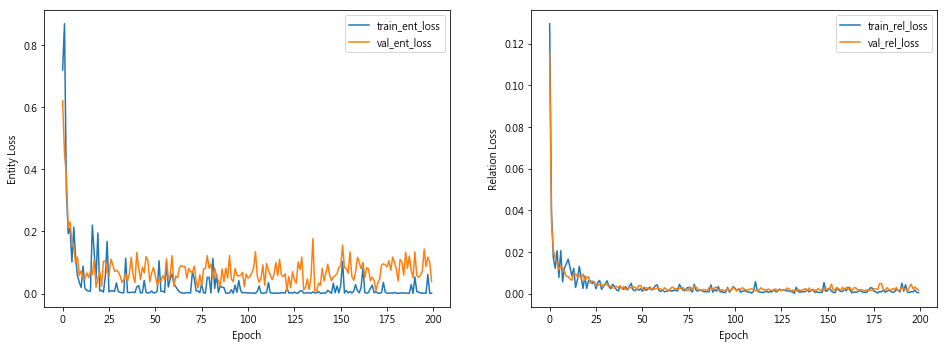

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt


plt.figure(figsize=(16, 12))
plt.subplot(2,2,1)
plt.plot(train_entloss_l, label='train_ent_loss')
plt.plot(val_entloss_l, label='val_ent_loss')
plt.xlabel("Epoch")
plt.ylabel("Entity Loss") 
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_relloss_l, label='train_rel_loss')
plt.plot(val_relloss_l, label='val_rel_loss')
plt.xlabel("Epoch")
plt.ylabel("Relation Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# # Check predictions after training
# with torch.no_grad():
#     r_choose = random_choose(input_var)
#     model.eval()
#     ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var, batch_ent.cuda() \
#                                        if USE_CUDA else batch_ent, isTrain=True)
    
#     batchsize = input_var[r_choose].size(0)
    
#     ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
#     ent_output = ent_argmax(ent_output, batchsize)
    
#     rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
#     print()
#     print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
#     print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    
#     print()
#     print("Entity loss : %.4f" % ent_loss)
#     print("Relation loss : %.4f" % rel_loss)

In [15]:
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('always') 

def evaluate_data(data_loader, raw_input, isTrain=False, silent=False):
    tps, fps, tns, fns = 0, 0, 0, 0
    y_ent_true_all, y_ent_pred_all = [], []
    y_rel_true_all, y_rel_pred_all = [], []
    print_every_batch = 5

    with torch.no_grad():
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(data_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain)

            batchsize = batch_x.size(0)

            ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
            ent_output = ent_argmax(ent_output, batchsize)

            rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
            rel_output = rel_argmax(rel_output, batchsize)

            
            if not silent:
                print()    
                print("Entity loss : %.4f" % ent_loss)
                print("Relation loss : %.4f" % rel_loss)
                print()
                print('===========================================')
                
#             elif step%print_every_batch==0:
#                 print()    
#                 print("Entity loss : %.4f" % ent_loss)
#                 print("Relation loss : %.4f" % rel_loss)
#                 print()
#                 print('===========================================')
            else:
                pass

            tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel = \
            batch_decode(ent_output, rel_output, batch_index, raw_input, batch_ent, batch_rel, silent)
            
            
            
            

            y_ent_true_all.extend(y_true_ent)
            y_ent_pred_all.extend(y_pred_ent)

            y_rel_true_all.extend(y_true_rel)
            y_rel_pred_all.extend(y_pred_rel)
            
            tps += tp
            fps += fp
            tns += tn
            fns += fn
        
        
        print()
        print("Entity detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_ent_true_all, y_ent_pred_all, average='micro', 
                                                  labels=range(len(schema['entity'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("Relation detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_rel_true_all, y_rel_pred_all, average='micro', 
                                              labels=range(len(schema['relation'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("ReferenceEntity+Relation score")
        print("%s \t %s \t %s \t    %s %s %s %s" % ('precision ', 'recall ', 'fbeta_score ', 'tp', 'fp', 'tn', 'fn'))
        p_r_f1 = p_r_fscore(tps, fps, tns, fns)
        print('%.3f \t\t %.3f \t\t %.3f \t\t    %d %d %d %d' % (p_r_f1[0], p_r_f1[1], p_r_f1[2], tps, fps, tns, fns))

            
            
def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel, silent):
    
    eval_ent_list_true_l, eval_rel_list_true_l = [], []
    eval_ent_list_pred_l, eval_rel_list_pred_l = [], []
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]     
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        pre_r_list, appear_error = decode_rel(e, r)      # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        pre_r_list = [list(set(i)) if type(i) is list else i for i in pre_r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
        
        true_r_list = true_r_list[:len_of_list]
        pre_r_list = pre_r_list[:len_of_list]
        
        
        # 評分用
        eval_ent_list_true, err_count = decode_ent(true_ent, schema)
        eval_rel_list_true = decode_rel_to_eval(true_r_list, schema, eval_ent_list_true)
        
        eval_ent_list_pred, err_count = decode_ent(pridict_ent, schema)
        eval_rel_list_pred = decode_rel_to_eval(pre_r_list, schema, eval_ent_list_pred)
        
        if not silent:
            print(word_list)
            print(true_ent)
            print(true_r_list)
            print()
            print('Predict output')
            print(pridict_ent)
            print(pre_r_list)
            print()
            print('True')
            print(eval_ent_list_true)
            print(eval_rel_list_true)
            print('predict')
            print(eval_ent_list_pred)
            print(eval_rel_list_pred)
            print("=====================================")
        
        eval_ent_list_true_l.append(eval_ent_list_true)
        eval_rel_list_true_l.append(eval_rel_list_true)
        eval_ent_list_pred_l.append(eval_ent_list_pred)
        eval_rel_list_pred_l.append(eval_rel_list_pred)
    
    
    e_score, y_true_ent, y_pred_ent = get_scores(eval_ent_list_true_l, eval_ent_list_pred_l, \
                                                 range(len(schema['entity'])),output_y=True)
    r_score, y_true_rel, y_pred_rel = get_scores(eval_rel_list_true_l, eval_rel_list_pred_l, \
                                                 range(len(schema['relation'])),output_y=True)
    
    tp, fp, tn, fn = relation_error_analysis(eval_rel_list_true_l, eval_rel_list_pred_l)
    
    if not silent:
        print('Batch entity score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(e_score)
        print()
        print('Batch relation score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(r_score)
        print()
        print('p_r_fscore')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(p_r_fscore(tp, fp, tn, fn), tp, fp, tn, fn)
        print('===========================================')
    
    return tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel
        
        



def decode_ent(pred_ent, schema):
    '''
    Aggregate entities from predicted tags
    Input:
    pred_ent=a list of entity tags in a sentence
    schema=the dictionary defining entities and relations
    Output: 
    ent_list=[(ent_start, ent_end, ent_type=eid_in_schema)]
    err_count=the number of bad tags
    '''
    ent_list = []
    ent_start = 0
    ent_end = 0
    state = {
        'ENT_SPAN': 0,
        'NO_ENT': 1
    }
    err_count = 0
    ent_type = ''
    sid = state['NO_ENT']
    for idx, e_tag in enumerate(pred_ent):
        bio = e_tag[0]
        type_tag = e_tag.split('-')[-1]
        if sid == state['NO_ENT']:
            if bio == 'B':
                ent_start = idx
                ent_type = get_eid_from_tag(type_tag, schema)
                sid = state['ENT_SPAN']
            elif bio == 'I':
                err_count += 1
        elif sid == state['ENT_SPAN']:
            if bio != 'I':
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                if bio == 'B':
                    ent_start = idx
                    ent_type = get_eid_from_tag(type_tag, schema)
                else:
                    sid = state['NO_ENT']
            elif ent_type != get_eid_from_tag(type_tag, schema):
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                err_count += 1
                sid = state['NO_ENT']
    if sid == state['ENT_SPAN']:
        ent_end = len(pred_ent) - 1
        ent_list.append((ent_start, ent_end, ent_type))
    return ent_list, err_count

def get_eid_from_tag(tag, schema):
    '''
    Assume schema is a dictionary in schema.txt
    return eid or -1 if no match is found
    '''
    for content in schema['entity'].values():
        if content['tag'] == tag:
            return content['eid']
    return -1



def decode_rel_to_eval(r_list, schema, ent_list):
    
    max_pair = 0
    for r in r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
    

    pair_idx = {}
    for pair in range(max_pair+1):
        for i, r in enumerate(r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==pair:
                        if pair not in pair_idx:
                            pair_idx[pair] = [i]
                        else:
                            pair_idx[pair].append(i)
    
    
#     # 算兩兩不同tag的數目
#     e_type_dict = {}
#     for e_pair in ent_list:
#         if e_pair[-1] not in e_type_dict:
#             e_type_dict[e_pair[-1]] = 1
#         else:
#             e_type_dict[e_pair[-1]] += 1
    
#     total_pair = 0
#     e_type_l = list(e_type_dict.values())
#     for i, ent_type_num_1 in enumerate(e_type_l):
#         for j, ent_type_num_2 in enumerate(e_type_l[i+1:]):
#             pair_num = ent_type_num_1*ent_type_num_2
#             total_pair += pair_num

    pair_list = []
    for i, e_pair_1 in enumerate(ent_list):
        for j, e_pair_2 in enumerate(ent_list[i+1:]):
            if e_pair_1[-1]!=e_pair_2[-1]:
                pair_list.append([e_pair_1, e_pair_2])
                
                
    
    
    eval_rel_list = []
    for pair in pair_idx:
        rel_loc = pair_idx[pair]
        for e_pairs in pair_list:
            check_pair = True
            first_start = e_pairs[0][0]
            first_end = e_pairs[0][1]
            sec_start = e_pairs[1][0]
            sec_end = e_pairs[1][1]
            
            first_l = list(range(first_start, first_end+1))
            sec_l = list(range(sec_start, sec_end+1))
            combine_l = first_l+sec_l

            
            check_in_entity = []
            for x in combine_l:
                if x in rel_loc:
                    check_in_entity.append(True)
                else:
                    check_in_entity.append(False)
                    check_pair = False
                    break             

            if all(check_in_entity)==True:
                for r in r_list[first_start]:
                    r_info = r.split('-')
                    
                    if int(r_info[1])==pair:
                        r_tag = get_rid_from_tag(r_info[0], schema)
                        e_pairs_copy = e_pairs
                        e_pairs_copy.append(r_tag)
                        eval_rel_list.append(tuple(e_pairs_copy))
    
    return eval_rel_list
    
        
def get_rid_from_tag(tag, schema):   
    for content in schema['relation'].values():
        if content['tag'] == tag:
            return content['rid']




def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error
        
        
def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_rel_loc(second_tag, schema)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                  
def check_rel_loc(second_tag, schema):
    convert_tag = ''

    for ent_content in schema['entity']:
        if schema['entity'][ent_content]['tag']==second_tag:
            convert_tag = ent_content
    
    rel_types = schema['relation'].values()

    for rel_content in schema['relation'].values():
        for AorB in rel_content['arguments']:
            if rel_content['arguments'][AorB]==convert_tag:
                return AorB
            

            
def get_scores(true_lists, pred_lists, labels, output_y=False):
    y_true, y_pred = [], []
    for t_list, p_list in zip(true_lists, pred_lists):
        yt, yp = align_yt_yp(t_list, p_list, labels)
        y_true.extend(yt)
        y_pred.extend(yp)
        
    scores = precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels)
    return scores, y_true, y_pred if output_y else scores

def align_yt_yp(truths, predictions, labels):
    '''
    Input:
        truths/predictions: list of true and predicted tuples, 
        with the leading entries as the structure and the last entry as the class,
        e.g., [(e1, e2, rel), ...]
        labels: sequence of valid class
    Output:
        yt: list of true class given a structure
        yp: list of predicted class given a structure
    '''
    yt, yp = [], []
    _ID_NONE = len(labels)
    true_dict = { t[:-1]: t[-1] for t in truths }
    for p in predictions:
        yt.append(true_dict.pop(p[:-1], _ID_NONE))
        yp.append(p[-1])
    for target in true_dict.values():
        yt.append(target)
        yp.append(_ID_NONE)
    return yt, yp



def is_neg_triple(t):
    return np.imag(t[-1]) > 0

def negate_triple(t):
    # Mark negative triples with imaginary relation id
    return (t[0], t[1], np.real(t[-1]).item() + 1j)

def posit_triple(t):
    return (t[0], t[1], np.real(t[-1]).item())

def has_edge(base_ptrs, rel, e):
    '''
    Assume a relation exist between an entity pair, 
    if all the tokens in the base entity point to those in entity e.
    '''
    tok_has_ptr_to_e = [tok_ptrs[rel].ge(e[0]).dot(tok_ptrs[rel].le(e[1])).item() > 0 
                        for tok_ptrs in base_ptrs]
    return len(tok_has_ptr_to_e) > 0 and all(tok_has_ptr_to_e)


def relation_error_analysis(true_rel_lists, rel_lists):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i, r_list in enumerate(rel_lists):
        true_pos = len([t for t in r_list if t in true_rel_lists[i]])
        all_true = len([t for t in true_rel_lists[i] if not is_neg_triple(t)])
        all_pos = len(r_list)
        tp += true_pos
        fn += all_true - true_pos
        fp += all_pos - true_pos
        tn += len([t for t in true_rel_lists[i] if is_neg_triple(t) and posit_triple(t) not in r_list])
    return tp, fp, tn, fn

def p_r_fscore(tp, fp, tn, fn, beta=1, eps=1e-8):
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r + eps))
    return p, r, f_beta

In [16]:
evaluate_data(dev_loader, raw_input_dev, isTrain=True)


Entity loss : 0.0636
Relation loss : 0.0017

['但', '對', '皮', '膚', '乾', '癢', '保', '濕', '及', '透', '亮', '很', '有', '幫', '助', '的', '喲']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '']

True
[(2, 4, 1), (6, 7, 0)]
[((2, 4, 1), (6, 7, 0), 0)]
predict
[(2, 4, 1), (6, 7, 0)]
[((2, 4, 1), (6, 7, 0), 0)]
['S', 't', 'e', 'p', '2', '.', '強', '化', '補', '水', '-', '嫩', '白', '蠶', '絲', '面', '膜', '-', '面', '膜', '非', '常', '薄', '貼', '，', '記', '得', '要', '把', '蠶', '絲', '面', '膜', '朝', '臉', '敷', '上', '後', '再', '把', '珍', '珠', '膜', '撕', '下', '布', '料', '採', '用', 

['“', '酵', '母', '萃', '取', '”', '搭', '配', '“', '小', '分', '子', '玻', '尿', '酸', '”', '及', '“', '牛', '奶', '蛋', '白', '”', '使', '乾', '燥', '肌', '膚', '充', '滿', '水', '分', '，', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyT

['溫', '和', '的', '成', '份', '讓', '敏', '感', '的', '肌', '膚', '也', '能', '輕', '鬆', '的', '美', '白']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(6, 10, 1), (16, 17, 0)]
[((6, 10, 1), (16, 17, 0), 0)]
predict
[(6, 10, 1), (16, 17, 0)]
[((6, 10, 1), (16, 17, 0), 0)]
['“', '酵', '母', '萃', '取', '”', '搭', '配', '“', '小', '分', '子', '玻', '尿', '酸', '”', '及', '“', '牛', '奶', '蛋', '白', '”', '使', '乾', '燥', '肌', '膚', '充', '滿', '水', '分', '，', '長', '效', '保', '濕']

['不', '過', '乾', '性', '肌', '膚', '敷', '完', '後', '可', '能', '要', '馬', '上', '擦', '點', '保', '濕', '的', '保', '養', '品', '不', '然', '皮', '膚', '會', '緊', '緊', '繃', '繃', '的', '喔']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'B-STAT', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', [], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '', '', '', '', '', '', '

['有', '些', '保', '濕', '面', '膜', '，', '我', '的', '敏', '感', '性', '膚', '質', '如', '果', '敷', '太', '久', '，', '就', '會', '開', '始', '發', '癢', '，', '這', '款', '一', '直', '敷', '到', '最', '後', '都', '很', '舒', '服', '呢']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(9


Entity loss : 0.0414
Relation loss : 0.0021

['使', '用', '了', '幾', '次', '，', '效', '果', '都', '不', '太', '令', '人', '滿', '意', '，', '也', '許', '是', '這', '款', '面', '膜', '主', '要', '強', '調', '的', '是', '緊', '緻', '功', '能', '，', '我', '的', '超', '乾', '肌', '得', '先', '把', '缺', '水', '問', '題', '解', '決', '了', '才', '能', '看', '出', '效', '果', '吧', '∼']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['若', '乾', '性', '肌', '膚', '使', '用', '會', '保', '濕', '度', '不', '足']
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O']
['', [], [], [], [], '', '', '', [], [], [], '', '']

Predict output
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O']
['', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

True
[(1, 4, 1), (8, 10, 0)]
[]
predict
[(1, 4, 1), (8, 10, 0)]
[((1, 4, 1), (8, 10, 0), 0)]
['我', '的', '美', '麗', '日', '記', '一', '直', '是', '我', '的', '愛', '用', '品', '之', '一', '，', '對', '於', '健', '康', '膚', '色', '油', '性', '混', '合', '肌', '的', '我', '，', '挑', '選', '面', '膜', '的', '重', '點', '就', '是', '-', '-', '-', '可', '以', '變', '白', '、', '保', '濕', '、', '不', '會', '黏', '黏', '的', '(', '很', '重', '要', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [17]:
# load test set

input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [18]:
evaluate_data(test_loader, raw_input_test, isTrain=True, )# silent=True)


Entity loss : 0.1026
Relation loss : 0.0027

['很', '多', '保', '養', '品', '都', '說', '能', '保', '濕', '，', '同', '樣', '強', '調', '保', '濕', '，', '凱', '薩', '琳', '覺', '得', '水', '之', '妍', '水', '漾', '保', '濕', '精', '華', '露', '的', '特', '點', '是', '它', '是', '專', '門', '為', '缺', '水', '和', '缺', '水', '性', '敏', '感', '膚', '質', '而', '設', '計', '，', '專', '著', '在', '皮', '膚', '的', '補', '水', '、', '保', '水', '和', '鎖', '水', '，', '而', '且', '還', '有', '獨', '家', '的', '配', '方', '“', 'A', 'q', 'u', 'a', 'g', 'e', 'n', 'i', 'u', 'm', '®', '”', '水', '漾', '因', '子']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['保', '濕', '度', '維', '持', '的', '算', '還', '不', '錯', ',', '但', '也', '不', '會', '有', '起', '床', '後', '皮', '膚', '大', '出', '油', '的', '感', '覺', '(', '我', '是', '乾', '性', '皮', '膚', '喔']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '']

Predict output
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['這', '次', '試', '用', '全', '效', '舒', '緩', '精', '華', '液', '，', '令', '敏', '感', '肌', '的', '我', '很', '滿', '意', '它', '的', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

True
[(13, 15, 1)]
[]
predict
[(6, 7, 0), (13, 15, 1)]
[((6, 7, 0), (13, 15, 1), 0)]
['這', '次', '新', '上', '市', '的', '肌', '研', '極', '潤', '健', '康', '化', '妝', '水', '(', 'N', 'T', '$', '4', '8', '0', '/', '1', '7', '0', 'm', 'l', ')', '是', '專', '門', '針', '對', '輕', '熟', '女', '女', '性', '不', '穩', '定', '的

['化', '妝', '水', '-', '>', 'P', 'r', 'o', 'f', '.', 'T', 'K', 'T', 'P', 'G', 'S', '-', 'V', 'E', '抗', '皺', '嫩', '膚', '精', '華', '液', '-', '>', '德', '果', '小', '甘', '菊', '敏', '感', '肌', '乳', '液']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

True
[(33, 35, 1)

['我', '的', '膚', '質', '為', '中', '性', '肌', '，', '冬', '天', '偏', '乾', '，', '夏', '天', '因', '長', '待', '在', '冷', '氣', '房', '裡', '面', '，', '容', '易', '有', '缺', '水', '出', '油', '的', '情', '況', '，', '所', '以', '要', '注', '重', '保', '濕', '，', '出', '油', '脫', '妝', '的', '情', '形', '才', '不', '會', '嚇', '到', '人']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

['這', '次', '所', '推', '出', '的', '是', '維', '他', '命', 'C', '升', '級', '版', '，', '裡', '面', '含', '有', '乙', '基', '維', '他', '命', 'C', '，', '加', '上', '兩', '種', '美', '白', '配', '方', '專', '利', '技', '術', '，', '還', '有', '特', '別', '添', '加', '抗', '敏', '成', '分', '讓', '敏', '感', '性', '肌', '膚', '也', '能', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['且', '有', '感', '受', '到', '滋', '潤', '乾', '燥', '肌', '膚', ',', '粗', '糙', '肌', '膚', '也', '慢', '慢', '有', '平', '滑', '柔', '嫩', '的', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '']

True
[(7, 10, 1), (22, 23, 0)]
[]
predict
[(7, 10, 1), (22, 23, 0)]
[((7, 10, 1), (22, 23, 0), 0)]
['保', '濕', '效', '果', '如', '果', '皮', '膚', '乾', '性', '一', '點', '的', '應', '該', '不', '夠']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O'

[[], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(25, 29, 1)]
[]
predict
[(0, 1, 0), (12, 13, 0), (25, 29, 1)]
[]
['在', '這', '秋', '冬', '交', '替', '的', '季', '節', '，', '天', '氣', '陰', '晴', '不', '定', '，', '使', '得', '肌', '膚', '常', '出', '現', '缺', '水', '的', '乾', '燥', '狀', '態', '，', '使', '用', '專', '科', '完', '美', '多', '效', '晚', '安', '水', '凝', '霜', '之', '後', '，', '肌', '膚', '乾', '燥', '問', '題', '明', '顯', '獲', '得', '改', '善', '，', '肌', '膚', '變', '得', '緊', '緻', '有', '光', '澤', '，', '光', '滑', '好', '撫', '摸']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC'

['整', '體', '來', '說', '，', '是', '個', '很', '不', '錯', '的', '美', '白', '產', '品', '，', '不', '乾', '燥', '過', '敏', '，', '還', '具', '滋', '潤', '度', '，', '能', '適', '合', '冬', '春', '交', '替', '之', '際', '易', '乾', '燥', '敏', '感', '的', '肌', '膚', '，', '光', '這', '點', '就', '值', '得', '推', '薦', '給', '大', '家']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['「', '彈', '潤', '型', '玻', '尿', '酸', '」', '可', '以', '使', '乾', '燥', '的', '肌', '膚', '瞬', '間', '變', '的', 'Q', '彈', '水', '潤', '，', '「', '持', '久', '型', '玻', '尿', '酸', '」', '則', '可', '緊', '密', '貼', '合', '肌', '膚', '達', '到', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '',

['覺', '得', '這', '款', '面', '膜', '只', '能', '單', '純', '滋', '潤', '乾', '燥', '肌', '膚', '，', '敷', '完', '馬', '上', '感', '覺', '美', '容', '液', '全', '被', '肌', '膚', '吸', '收', '可', '是', '維', '持', '度', '我', '覺', '得', '還', '好', '，', '要', '即', '使', '進', '行', '日', '常', '保', '養', '擦', '乳', '霜', '來', '鎖', '住', '水', '分', '就', '更', '完', '美', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['但', '保', '濕', '和', '控', '油', '都', '兼', '具', '，', '所', '以', '特', '別', '推', '薦', '混', '合', '肌', '使', '用', '喔']
['O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

Predict output
['O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

True
[(1, 2, 0), (16, 18, 1)]
[((1, 2, 0), (16, 18, 1), 0)]
predict
[(1, 2, 0), (16, 18, 1)]
[((1, 2, 0), (16, 18, 1), 0)]
['否', '則', '保', '濕', '度', '對', '乾', '肌', '還', '是', '嫌', '不', '足']
['O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', [],

['因', '為', '每', '當', '在', '換', '季', '時', '，', '敏', '感', '性', '肌', '膚', '總', '是', '會', '因', '為', '季', '節', '變', '化', '而', '引', '起', '肌', '膚', '不', '適', '，', '尤', '其', '冬', '天', '容', '易', '有', '乾', '癢', '的', '情', '形', '，', '所', '以', '這', '時', '的', '保', '養', '，', '總', '要', '特', '別', '注', '重', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 

['結', '合', '多', '糖', '體', '、', '甘', '菊', '、', '山', '楂', '、', '牡', '丹', '等', '天', '然', '植', '物', '活', '性', '精', '華', '，', '還', '有', '維', '他', '命', 'B', '5', '、', '白', '藜', '蘆', '醇', '等', '的', '專', '利', '鎮', '定', '複', '合', '成', '分', '，', '對', '於', '敏', '感', '肌', '膚', '的', '泛', '紅', '症', '狀', '，', '可', '以', '立', '即', '鎮', '定', '舒', '緩', '，', '讓', '膚', '色', '呈', '現', '均', '勻', '樣', '，', '是', '一', '款', '很', '有', '修', '護', '防', '禦', '的', '精', '華', '液', '唷']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['整', '體', '來', '說', '是', '一', '項', '不', '錯', '用', '的', '美', '白', '精', '華', '，', '推', '薦', '給', '想', '淡', '化', '痘', '疤', '、', '怕', '油', '膩', '的', '敏', '感', '肌', '使', '用', '，', '3', '0', 'm', 'l', '$', '2', '5', '0', '0', '以', '美', '白', '精', '華', '的', '價', '位', '來', '說', '算', '中', '等', '，', '若', '搭', '配', '特', '惠', '組', '合', '會', '考', '慮', '購', '入', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['雖', '適', '合', '在', '夏', '天', '使', '用', '，', '不', '過', '對', '乾', '性', '肌', '膚', '來', '說', '，', '若', '後', '續', '保', '養', '不', '即', '時', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '']

True
[(12, 15, 1)]
[]
predict
[(12, 15, 1), (22, 23, 0)]
[((12, 15, 1), (22, 23, 0), 0)]
['如', '果', '是', '乾', '肌', '的', '膚', '質', '可', '能', '需', '要', '加', '強', '保', '養', '的', '潤', '澤', '品', '後', '再', '使', '

['前', '陣', '子', '因', '疏', '於', '保', '養', '而', '略', '嫌', '乾', '燥', '的', '肌', '膚', '，', '立', '刻', '又', '充', '滿', '了', '活', '力']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

True
[(11, 15, 1)]
[]
predict
[(6, 7, 0), (11, 15, 1)]
[((6, 7, 0), (11, 15, 1), 0)]
['整', '體', '來', '說', ',', '這', '款', '面', '膜', '的', '保', '濕', '度', '、', '舒', '緩', '力', '、', '維', '持', '度', '和', '服', '貼', '度', '都', '很', '不', '錯', ',', '不', '過', '面', '


Entity loss : 0.0541
Relation loss : 0.0023

['我', '是', '油', '性', '敏', '感', '肌', '膚', '，', '一', '方', '面', '要', '加', '強', '保', '濕', '，', '也', '要', '控', '制', '油', '光', '，', '所', '以', '太', '滋', '養', '的', '產', '品', '是', '不', '適', '合', '我', '的']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['基', '本', '上', '是', '還', '算', '保', '濕', '的', '產', '品', '，', '乾', '性', '肌', '膚', '應', '該', '會', '蠻', '喜', '歡', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '']

True
[(6, 7, 0), (12, 15, 1)]
[((6, 7, 0), (12, 15, 1), 0)]
predict
[(12, 15, 1)]
[]
['但', '如', '果', '是', '油', '性', '肌', '膚', '、', '想', '美', '白', '的', '，', '還', '蠻', '適', '合', '這', '項', '產', '品', '的']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['個', '人', '有', '特', '別', '只', '單', '一', '用', '這', '一', '罐', '凝', '膠', '，', '確', '實', '滿', '保', '濕', '的', '（', '本', '人', '的', '臉', '是', '混', '合', '肌', '，', '兩', '頰', '很', '容', '易', '因', '為', '保', '濕', '不', '夠', '而', '感', '到', '緊', '繃', '，', '如', '下', '圖', '有', '手', '部', '測', '試', '圖', '）', '，', '上', '妝', '的', '時', '候', '有', '比', '使', '用', '前', '來', '的', '不', '易', '脫', '妝', '，', '感', '覺', '還', '不', '錯']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', 


Entity loss : 0.0584
Relation loss : 0.0021

['但', '是', '保', '濕', '的', '部', '份', '，', '對', '我', '這', '種', '油', '性', '肌', '膚', '的', '來', '說', '是', '剛', '剛', '好', '，', '使', '用', '後', '就', '會', '覺', '得', '皮', '膚', '水', '水', '嫩', '嫩', '的']
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '',

['收', '到', '寶', '藝', '這', '瓶', '乳', '霜', '打', '開', '時', '，', '有', '點', '嚇', '到', '，', '因', '為', '很', '少', '看', '到', '”', '橘', '色', '”', '的', '乳', '液', '，', '感', '覺', '很', '像', '色', '素', '，', '不', '過', '擦', '上', '臉', '後', '就', '不', '會', '有', '這', '疑', '慮', '了', '，', '這', '款', '乳', '液', '因', '為', '訴', '求', '保', '濕', '、', '針', '對', '特', '別', '乾', '燥', '的', '膚', '質', '，', '所', '以', '質', '地', '很', '”', '濃', '厚', '”', '(']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['再', '加', '上', '它', '的', '保', '濕', '效', '果', '很', '讓', '我', '滿', '意', ',', '我', '是', '乾', '性', '肌', '膚', ',', '用', '起', '來', '蠻', '夠', '保', '濕', '的', ',']
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'App

['我', '是', '混', '合', '性', '肌', '膚', '歐', '(', '乾', '乾', '有', '皮', '削', '的', '皮', '膚', '，', '等', '會', '兒', '看', '保', '濕', '情', '況', ')']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', [], '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

True
[(2, 6, 1)]
[]
predict
[(2, 6, 1), (10, 10, 1), (22, 23, 0)]
[]
['基', '本', '上', '我', '是', '油', '性', '肌', '，', '但', '又', '是', '會', '乾', '到', '狂', '出', '油', '.', '.', '.', '所', '以', '我', '需', '要', '保', '濕', '度', '很', '高', '的', '臉', '部', '產', '品', '這', '款', '洗', '顏', '皂', '霜', '，', '他', '沒

['這', '瓶', '凝', '露', '具', '有', '6', '2', '種', '高', '效', '保', '濕', '美', '肌', '成', '分', '，', '是', 'M', 'e', 'd', 'i', 'p', 'l', 'u', 's', '社', '長', '自', '行', '開', '發', '過', '敏', '性', '肌', '膚', '也', '能', '使', '用', '的', '保', '養', '品']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-FUNC', 'B-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
['', '', '', '', '', '', '


Entity loss : 0.1866
Relation loss : 0.0031

['不', '過', '在', '這', '季', '節', '交', '替', '的', '時', '節', '，', '我', '本', '身', '又', '是', '屬', '於', '較', '容', '易', '乾', '燥', '的', '肌', '膚', '，', '所', '以', '才', '覺', '得', '保', '濕', '效', '果', '還', '好', '吧', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

['這', '款', '對', '我', '這', '個', '敏', '感', '肌', '來', '說', '用', '也', '很', '棒', '，', '一', '些', '小', '泛', '紅', '都', '可', '以', '改', '善', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
predict
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
['我', '這', '2', '~', '3', '年', 

['本', '身', '屬', '於', '混', '合', '偏', '油', '性', '肌', '膚', '，', '最', '近', '越', '來', '越', '熱', '的', '天', '氣', '，', '使', '用', '此', '產', '品', '，', '不', '會', '過', '於', '黏', '膩', '，', '保', '濕', '也', '可', '以']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['

['使', '用', '這', '粉', '餅', '的', '感', '覺', '整', '體', '還', '不', '錯', '沒', '有', '什', '麼', '特', '別', '味', '道', '對', '於', '服', '貼', '度', '還', '不', '錯', '遮', '瑕', '度', '還', '好', '持', '久', '度', '也', '是', '尚', '可', '但', '對', '於', '保', '濕', '上', '也', '不', '錯', '擦', '上', '去', '不', '會', '很', '乾', '也', '不', '會', '很', '油', '還', '滿', '舒', '服', '的', '很', '適', '合', '油', '性', '肌', '使', '用', '也', '不', '會', '長', '痘', '痘', '擦', '上', '去', '感', '覺', '很', '自', '然', '透', '氣', '度', '也', '不', '錯']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ''

['原', '本', '乾', '燥', '的', '肌', '膚', '可', '得', '到', '舒', '緩']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(2, 6, 1), (10, 11, 0)]
[((2, 6, 1), (10, 11, 0), 0)]
predict
[(2, 6, 1), (10, 11, 0)]
[((2, 6, 1), (10, 11, 0), 0)]
['乾', '肌', '可', '能', '就', '更', '顯', '保', '濕', '不', '夠', '力', '了']
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', [], [], '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['

['缺', '點', '的', '話', '大', '概', '就', '是', '混', '合', '肌', '的', '人', '較', '乾', '的', '兩', '頰', '保', '濕', '必', '須', '做', '好', '，', '推', '薦', '給', '混', '合', '肌', '、', '油', '肌', '人']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-STAT', 'I-STAT', 'O']
['', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', [], [], '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-STAT', 'I-STAT', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-1-A', 'ApplyTo-0-A'], ['ApplyTo-1-A', 'ApplyTo-0-A'], '', '', '', '', '', '', '', '', ['ApplyTo-1-B'], 

['整', '體', '來', '說', '，', '試', '用', '過', 'C', 'u', 'r', 'e', 'l', '珂', '潤', '潤', '浸', '保', '濕', '屏', '護', '力', 'B', 'B', '霜', '後', '，', '就', '不', '用', '再', '瓶', '瓶', '罐', '罐', '的', '一', '層', '一', '層', '使', '用', '防', '曬', '、', '隔', '離', '、', '遮', '暇', '，', '總', '算', '可', '以', '一', '瓶', '搞', '定', '，', '又', '滿', '足', '乾', '燥', '敏', '感', '肌', '的', '保', '濕', '和', '防', '護', '力']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''


Entity loss : 0.1488
Relation loss : 0.0025

['擦', '上', '後', '肌', '膚', '乾', '燥', '迅', '速', '得', '到', '緩', '解', ',', '也', '真', '的', '相', '當', '保', '濕', ',', '薄', '薄', '一', '層', '也', '沒', '有', '任', '何', '悶', '膩', '的', '感', '覺']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], '', '', '', '', [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', ''

['用', '了', '約', '半', '瓶', '，', '臉', '部', '保', '濕', '變', '高', '，', '臉', '也', '變', '的', '明', '亮', '，', '不', '過', '夏', '天', '我', '肌', '膚', '較', '容', '易', '出', '油', '的', '膚', '質', '，', '變', '的', '更', '明', '顯', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [

['整', '體', '使', '用', '下', '來', '，', '保', '濕', '水', '嫩', '的', '效', '果', '一', '級', '棒', '，', '而', '且', '真', '的', '有', '效', '改', '善', '肌', '膚', '乾', '燥', '暗', '沉', '問', '題']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

True
[(26, 29, 1)]
[]
predict
[(7, 8, 0), (26, 29, 1)]
[((7, 8, 0), 

['最', '近', '天', '氣', '冷', '一', '定', '是', '要', '加', '強', '保', '濕', '和', '保', '養', '囉', '~', '這', '年', '頭', '保', '養', '已', '是', '不', '分', '男', '女', '，', '每', '個', '人', '都', '會', '遇', '到', '的', '天', '冷', '皮', '膚', '乾', '燥', '掉', '屑', '的', '問', '題', '，', '我', '個', '人', '是', '比', '較', '偏', '向', '”', '預', '防', '勝', '治', '療', '”', '，', '做', '好', '保', '濕', '更', '是', '逆', '行', '老', '化', '的', '絕', '對', '關', '鍵']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [],

['個', '人', '屬', '混', '合', '性', '膚', '質', '，', '一', '年', '四', '季', '最', '重', '視', '的', '就', '是', '保', '濕']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(3, 7, 1)]
[]
predict
[(3, 7, 1), (19, 20, 0)]
[((3, 7, 1), (19, 20, 0), 0)]
['舒', '緩', '乾', '燥', '泛', '紅', '的', '能', '力', '很', '好', '，', '也', '適', '合', '敏', '感', '肌', '使', '用']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'],

['我', '是', '混', '合', '性', '肌', '膚', ',', '在', '化', '妝', '水', '後', '使', '用', '不', '用', '在', '上', '保', '濕', '乳', '液', ',', '就', '可', '以', '兼', '顧', '保', '濕', '乳', '液', '+', '防', '曬', '.', '很', '方', '便', '.']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B', 'Appl

['甚', '至', '在', '不', '開', '冷', '氣', '的', '夏', '天', '，', '擦', '完', '水', '奇', '蹟', '修', '護', '保', '濕', '精', '華', '後', '，', '不', '再', '加', '擦', '乳', '液', '也', '不', '用', '擔', '心', '皮', '膚', '乾', '燥', '缺', '水']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', 

['這', '瓶', '拿', '來', '當', '混', '合', '性', '皮', '膚', '的', '保', '濕', '步', '驟', '用', '也', '是', 'o', 'k', '的', '唷', '~']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '']

True
[(5, 9, 1), (11, 12, 0)]
[((5, 9, 1), (11, 12, 0), 0)]
predict
[(5, 9, 1), (11, 12, 0)]
[((5, 9, 1), (11, 12, 0), 0)]
['這', '秋', '日', '時', '節', '，', '洗', '完', '臉', '將', '臉', '蛋', '水', '分', '拭'

['我', '是', '混', '合', '性', '肌', '膚', '，', '夏', '天', '是', '需', '要', '用', '清', '爽', '一', '點', '的', '保', '濕', '乳', '液']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

True
[(2, 6, 1)]
[]
predict
[(2, 6, 1), (19, 20, 0)]
[((2, 6, 1), (19, 20, 0), 0)]
['原', '本', '肌', '膚', '敏', '感', '泛', '紅', '的', '部', '分', '也', '舒', '緩', '許', '多']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'

['吸', '收', '和', '保', '濕', '度', '覺', '得', '還', '不', '錯', '，', '可', '以', '讓', '乾', '燥', '的', '肌', '膚', '舒', '緩', '一', '下', '，', '細', '紋', '改', '善', '度', '覺', '得', '差', '不', '多', '，', '哈', '~', '~', '眼', '周', '肌', '膚', '覺', '得', '有', '變', '明', '亮', '一', '點']
['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', '

['所', '以', '對', '混', '合', '性', '的', '皮', '膚', '是', '滿', '剛', '好', '不', '油', '膩', '又', '可', '以', '保', '濕', '.', '滿', '適', '合', '夏', '天', '外', '出', '又', '熱', '又', '要', '待', '冷', '氣', '房', '的', '環', '境', '.']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['Ap

['可', '能', '本', '身', '不', '是', '易', '敏', '感', '膚', '質', ',', '所', '以', '我', '還', '蠻', '願', '意', '去', '試', '用', '各', '抗', '老', '的', '保', '養', '產', '品', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '']

True
[(7, 10, 1)]
[]
predict
[(7, 10, 1), (26, 27, 0)]
[((7, 10, 1), (26, 27, 0), 0)]
['上', '圖', '持', '續', '使', '用', '2', '周', '後', '.', 

['總', '的', '來', '說', ':', '若', '是', '尋', '求', '淡', '斑', '，', '此', '商', '品', '的', '功', '能', '仍', '有', '待', '應', '證', '，', '但', '是', '就', '乾', '性', '皮', '膚', '來', '說', '，', '保', '濕', '度', '與', '持', '久', '度', '是', '可', '以', '做', '為', '購', '買', '選', '項', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ST

['有', '時', '洗', '完', '臉', ',', '只', '擦', '這', '個', ',', '皮', '膚', '的', '保', '濕', '度', '就', '很', '夠', '了', '而', '且', '用', '起', '來', '很', '清', '爽', ',', '油', '性', '肌', '也', '可', '用', '除', '了', '味', '道', '不', '喜', '歡', '以', '為', ',', '其', '實', '值', '得', '推', '薦']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['因', '為', '我', '是', '油', '性', '肌', '.', '.', '這', '瓶', '我', '用', '我', '覺', '得', '保', '濕', '也', '夠', '.', '.', '也', '不', '需', '要', '在', '擦', '別', '的']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '']

True
[(4, 6, 1), (16, 17, 0)]
[((4, 6, 1), (16, 17, 0), 0)]
predict
[(4, 6, 1), (16, 17, 0)]
[((4, 6, 1), (1

['保', '濕', '對', '我', '來', '說', '可', '以', ',', '混', '合', '肌', '的', '我', '再', '擦', '點', '乳', '液', '就', '夠']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

True
[(0, 1, 0), (9, 11, 1)]
[((0, 1, 0), (9, 11, 1), 0)]
predict
[(0, 1, 0), (9, 11, 1)]
[((0, 1, 0), (9, 11, 1), 0)]
['但', '這', '瓶', 'P', 'r', 'e', 'v', 'a', 'g', 'e', '艾', '地', '苯', '全', '能', '保', '濕', '精', '華', '乳', '，', '對', '於', '敏', '感', '肌', '膚', '也', '無', '負', '擔', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O',

['我', '覺', '得', '這', '款', '比', '較', '適', '合', '中', '偏', '乾', '肌', '用', ',', '應', '該', '會', '覺', '得', '蠻', '保', '濕', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

True
[(11, 12, 1), (21, 22, 0)]
[((11, 12, 1), (21, 22, 0), 0)]
predict
[(11, 12, 1), (21, 22, 0)]
[((11, 12, 1), (21, 22, 0), 0)]
['前', '兩', '個', '禮', '拜', ',', '因', '為', '氣', '溫', '變', '化', ',', '鼻', '頭', '有', '點', '脫', '屑', ',', '將', '精', '華', '液', '倒', '多', '一', '點', '敷', '在', 

['擦', '完', '之', '後', '又', '很', '保', '濕', '，', '更', '是', '油', '性', '膚', '質', '的', '福', '音', '，', '因', '有', '著', '上', '述', '優', '點', '所', '以', '不', '致', '粉', '刺', '喲']
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Tru

['4', '.', '肌', '膚', '感', '受', '：', '爽', '膚', '舒', '緩', '不', '黏', '膩', '，', '一', '抹', '即', '勻', '，', '肌', '膚', '吸', '收', '後', '看', '得', '到', '水', '潤', '感', '，', '補', '給', '肌', '膚', '水', '份', '，', '解', '決', '肌', '膚', '乾', '燥', '，', '使', '用', '期', '間', '無', '過', '敏', '現', '象']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['本', '身', '是', '油', '性', '肌', '，', '長', '期', '待', '在', '乾', '燥', '的', '冷', '氣', '房', '裡', '工', '作', '，', '皮', '膚', '容', '易', '缺', '水', '、', '出', '油', '，', '在', '選', '擇', '底', '妝', '時', '很', '重', '視', '保', '濕', '及', '控', '油', '力']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '',


Entity loss : 0.1497
Relation loss : 0.0027

['舒', '緩', '鎮', '定', '效', '果', '還', '可', '以', '.', '.', '我', '是', '敏', '感', '肌', '.', '.', '第', '一', '次', '用', '時', '兩', '頰', '有', '點', '小', '小', '癢', '.', '.']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 1, 0),

['產', '品', '強', '調', '是', '敏', '感', '性', '肌', '膚', '適', '用', '的', '保', '濕', '調', '理', '霜']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '']

True
[(5, 9, 1)]
[]
predict
[(5, 9, 1), (13, 14, 0)]
[((5, 9, 1), (13, 14, 0), 0)]
['我', '是', '屬', '於', '混', '合', '型', '肌', '膚', '，', '在', '保', '養', '上', '，', '既', '是', '需', '要', '保', '濕', '，', '也', '同', '時', '需', '要', '滋', '潤']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', 

['但', '這', '支', '對', '混', '合', '性', '膚', '質', '在', '冬', '天', '的', '保', '濕', '亮', '白', '度', '都', '蠻', '夠', '的']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '']

True
[(4, 8, 1), (13, 14, 0)]
[((4, 8, 1), (13, 14, 0), 0)]
predict
[(4, 8, 1), (13, 14, 0)]
[((4, 8, 1), (13, 14, 0), 0)]
['很', '清', '爽', '，', '但', '是', '對', '我', '敏', '乾', '肌', '卻', '不', '夠', '保', '濕']
['O', 'O', 'O', 

['總', '而', '言', '之', '~', '~', '對', '於', '乾', '性', '肌', '的', '我', '會', '覺', '得', '有', '點', '難', '推', '開', '~', '事', '先', '臉', '上', '要', '先', '做', '好', '保', '濕', '手', '續', '，', '才', '可', '以', '讓', '這', '商', '品', '加', '分', '~', '~', '但', '這', '點', '是', '可', '以', '克', '服', '的', '~', '~', '所', '以', '我', '還', '是', '推', '薦', '給', '大', '家', '摟', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output


In [19]:
def continue_train():
    
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
    criterion_rel = nn.NLLLoss()
    
    n_iters = 1
    print_every = 12

    train_entloss_l = []
    val_entloss_l = []
    train_relloss_l = []
    val_relloss_l = []

    loss = 0
    
    for epoch in tqdm(range(n_iters)):  
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
            model.train()
            optimizer.zero_grad()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            batch_ent = batch_ent.view(batchsize*MAX_LEN)
            batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)

            entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
            relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
            loss = entloss+relloss

            loss.backward()
            optimizer.step()


        train_entloss_l.append(entloss.cpu())
        train_relloss_l.append(relloss.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))

        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
            val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))

        val_entloss_l.append(val_entloss.cpu())
        val_relloss_l.append(val_relloss.cpu())

        
        
        evaluate_data(loader, raw_input, isTrain=True, silent=True)
        
        print()
        print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
              % (epoch+1, entloss, relloss, loss))
        print("      %s  | val ent loss %.4f | val rel loss %.4f"
              % (" "*len(str(epoch+1)), val_entloss, val_relloss))
        

In [20]:
# continue_train()

In [21]:
# evaluate_data(dev_loader, raw_input_dev, isTrain=True)

In [22]:
# evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)

In [23]:
evaluate_data(dev_loader, raw_input_dev, isTrain=False)


Entity loss : 0.0355
Relation loss : 0.0018

['“', '酵', '母', '萃', '取', '”', '搭', '配', '“', '小', '分', '子', '玻', '尿', '酸', '”', '及', '“', '牛', '奶', '蛋', '白', '”', '使', '乾', '燥', '肌', '膚', '充', '滿', '水', '分', '，', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

['極', '效', '肌', '因', '修', '護', '巨', '藻', '、', '齒', '缘', '墨', '角', '藻', '複', '合', '水', '解', '酵', '母', '提', '取', '物', '，', '浸', '透', '濕', '潤', '乾', '燥', '肌', '膚', '，', '增', '強', '防', '護', '屏', '障', '，', '協', '同', '蘆', '薈', '、', '山', '金', '車', '及', '光', '果', '甘', '草', '植', '萃', '精', '華', '，', '深', '度', '安', '撫', '同', '時', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '拋', '開', '惱', '人', '的', '乾', '燥', '缺', '水', '不', '安', '讓', '肌', '膚', '穩', '定']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['溫', '和', '的', '成', '份', '讓', '敏', '感', '的', '肌', '膚', '也', '能', '輕', '鬆', '的', '美', '白']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(6, 10, 1), (16, 17, 0)]
[((6, 10, 1), (16, 17, 0), 0)]
predict
[(6, 10, 1), (16, 17, 0)]
[((6, 10, 1), (16, 17, 0), 0)]
['本', '產', '品', '適', '合', '一', '般', '膚', '質', '及', '敏', '感', '性', '膚', '質', '的', '日', '常', '保', '養', '，', '也', '很', '適', '合', '急', '救', '乾', '荒', '缺', '水', '的', '肌', '膚', '，', '保', '濕',

['洗', '完', '臉', '後', '，', '我', '將', '「', '我', '的', '美', '麗', '日', '記', '」', '南', '極', '冰', '河', '醣', '蛋', '白', '滲', '透', '保', '濕', '面', '膜', '敷', '在', '臉', '上', '，', '經', '過', '2', '0', '分', '鐘', '後', '，', '將', '面', '膜', '從', '臉', '部', '由', '下', '往', '上', '撕', '下', '，', '再', '用', '清', '水', '將', '面', '膜', '清', '洗', '乾', '淨', '後', '，', '從', '鏡', '子', '中', '我', '看', '到', '臉', '部', '肌', '膚', '乾', '燥', '缺', '水', '的', '現', '象', '消', '失', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['但', '對', '皮', '膚', '乾', '癢', '保', '濕', '及', '透', '亮', '很', '有', '幫', '助', '的', '喲']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '']

True
[(2, 4, 1), (6, 7, 0)]
[((2, 4, 1), (6, 7, 0), 0)]
predict
[(2, 4, 1), (6, 7, 0)]
[((2, 4, 1), (6, 7, 0), 0)]
['“', '酵', '母', '萃', '取', '”', '搭', '配', '“', '小', '分', '子', '玻', '尿', '酸', '”', '及', '“', '牛', '奶', '蛋', '白', '”', '使', '乾', '燥', '肌', '膚', '充', '滿', '水', '分', '，', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['這', '款', '面', '膜', '它', '強', '調', '乾', '肌', '及', '肌', '膚', '鬆', '弛', '.', '.', '.', '等', ',', '但', '我', '發', '現', '緊', '緻', '的', '部', '份', '不', '是', '那', '麼', '明', '顯', ',', '但', '保', '濕', '部', '分', '我', '倒', '是', '很']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['A

['顧', '名', '思', '義', '這', '是', '一', '款', '晚', '安', '凍', '膜', '，', '乾', '肌', '我', '本', '人', '於', '晚', '上', '卸', '妝', '洗', '臉', '洗', '澡', '後', '睡', '前', '保', '養', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

True
[(13, 14, 1), (30, 31, 0)]
[((13, 14, 1), (30, 

In [24]:
evaluate_data(test_loader, raw_input_test, isTrain=False,  )# silent=True)


Entity loss : 0.0919
Relation loss : 0.0013

['滿', '意', '.', '.', '滿', '意', '滋', '潤', '了', '冬', '天', '乾', '燥', '的', '肌', '膚', '讓', '臉', '頰', '容', '易', '保', '濕', '有', '水', '嫩', '的', '感', '覺', '質', '地', '細', '緻', '好', '推', '展', '吸', '收', '迅', '速', '不', '會', '因', '為', '多', '一', '層', '保', '養', '程', '序', '而', '費', '時', '呈', '現', '的', '效', '果', '很', '符', '合', '產', '品', '訴', '求', '的', '重', '點', '值', '得', '列', '入', '保', '養', '品', '的', '購', '買', '清', '單']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0

['看', '外', '包', '裝', '照', '片', '就', '知', '道', '是', 'N', 'A', '鈉', '元', '素', '喔', '~', 'N', 'a', '玻', '尿', '酸', '納', '=', '保', '濕', '，', '缺', '水', '乾', '燥', '肌', '，', '適', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ''

['這', '瓶', '拿', '來', '當', '混', '合', '性', '皮', '膚', '的', '保', '濕', '步', '驟', '用', '也', '是', 'o', 'k', '的', '唷', '~']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '']

True
[(5, 9, 1), (11, 12, 0)]
[((5, 9, 1), (11, 12, 0), 0)]
predict
[(5, 9, 1), (11, 12, 0)]
[((5, 9, 1), (11, 12, 0), 0)]
['此', '粉', '底', '液', '還', '遮', '瑕', '度', '還', '蠻', '好', '的', ',', '所', '以'

['卸', '妝', '液', '含', '有', '水', '蓮', '精', '華', '與', 'V', 'i', 't', 'B', '5', '可', '以', '保', '濕', '修', '護', '肌', '膚', ',', '連', '敏', '感', '性', '肌', '膚', '也', '適', '用', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '']

True
[(17, 18, 0), (25, 29, 1)]
[((17, 18, 0)

['推', '薦', '給', '喜', '歡', '簡', '單', '保', '養', '的', '敏', '感', '肌', '朋', '友', ':', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], '', [], [], [], '', '', '', '']

True
[(7, 8, 0), (10, 12, 1)]
[((7, 8, 0), (10, 12, 1), 0)]
predict
[(7, 8, 0), (10, 12, 1)]
[]
['乾', '性', '肌', '膚', '可', '能', '需', '要', '多', '一', '層', '保', '濕', '的', '化', '妝', '水', '會', '比', '較', '好', '囉', '^', '^']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '']

Predic

['可', '能', '本', '身', '不', '是', '易', '敏', '感', '膚', '質', ',', '所', '以', '我', '還', '蠻', '願', '意', '去', '試', '用', '各', '抗', '老', '的', '保', '養', '產', '品', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

True
[(7, 10, 1)]
[]
predict
[(7, 10, 1), (26, 27, 0)]
[]
['個', '人', '覺', '得', '很', '保', '濕', '~', '~', '之', '後', '所', '擦', '的', '保', '養', '品', '~', '都', '不', '會', '感', '覺', '皮', '膚', '乾', '燥']
['O', 'O', 'O', 'O', 

['怕', '油', '肌', '膚', '可', '酌', '量', '減', '少', '使', '用', '2', '~', '3', '滴', '調', '整', '用', '量', '，', '再', '以', '精', '華', '液', '與', '乳', '霜', '加', '強', '保', '養']
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], []]

True
[(1, 3, 1)]
[]
predict
[(1, 3, 1), (30, 31, 0)]
[]
['否', '則', '保', '濕', '度', '對', '乾', '肌', '還', '是', '嫌', '不', '足']
['O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O',

['我', '算', '是', '很', '敏', '感', '的', '膚', '質', '，', '擦', '了', '這', '個', '之', '後', '，', '明', '顯', '覺', '得', '皮', '膚', '較', '沒', '有', '先', '前', '乾', '，', '很', '保', '濕', '，', '也', '不', '會', '有', '黏', '黏', '的', '感', '覺', '，', '一', '下', '子', '就', '會', '被', '完', '全', '的', '吸', '收', '，', '單', '價', '雖', '不', '便', '宜', '，', '但', '擦', '起', '來', '很', '令', '人', '滿', '意', '，', '等', '用', '完', '會', '想', '再', '買', '來', '保', '養', '的', '好', '東', '西']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['

['非', '常', '推', '薦', '秋', '冬', '急', '需', '保', '濕', '的', '乾', '燥', '肌', '膚', '使', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

True
[(8, 9, 0), (11, 14, 1)]
[((8, 9, 0), (11, 14, 1), 0)]
predict
[(8, 9, 0), (11, 14, 1)]
[((8, 9, 0), (11, 14, 1), 0)]
['打', '開', '來', '的', '顏', '色', '竟', '然', '是', '芋', '紫', '色', ',', '嚇', '了', '一', '跳', '說', '~', '不', '過', '香', '味', '不', '會', '太', '香', ',', '一', '抹', '在', '臉', '上', '很', '快', '就', '吸', '收', '了', ',', '一', '點', '都', '不', '黏',

['我', '本', '身', '是', '油', '性', '肌', '膚', '，', '很', '怕', '用', '起', '來', '太', '黏', '的', '保', '養', '品', '，', '大', '多', '乳', '霜', '因', '為', '要', '保', '濕', '容', '易', '較', '滋', '潤', '黏', '膩', '，', '但', '這', '瓶', '對', '我', '來', '說', '，', '用', '起', '來', '完', '全', '不', '黏', '，', '很', '快', '就', '被', '肌', '膚', '吸', '收', '了', '，', '隔', '天', '早', '上', '起', '床', '也', '較', '沒', '有', '出', '油', '，', '但', '對', '乾', '性', '肌', '膚', '不', '知', '道', '會', '不', '會', '不', '夠']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '',

['沒', '有', '添', '加', '酒', '精', '及', '香', '料', ',', '在', '這', '個', '季', '節', '交', '換', '變', '化', '之', '際', '用', '起', '來', '覺', '得', '很', '舒', '服', ',', '原', '本', '每', '年', '天', '氣', '變', '冷', '會', '有', '些', '小', '脫', '皮', '的', '皮', '膚', '也', '安', '定', '很', '多', ',', '就', '我', '油', '性', '肌', '膚', '來', '說', '秋', '冬', '使', '用', '真', '的', '很', '剛', '好', ',', '皮', '膚', '也', '不', '太', '會', '出', '油', ',', '以', '基', '礎', '保', '養', '而', '言', '我', '覺', '得', 'C', '/', 'P', '值', '很', '高']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '',

['C', 'O', 'L', 'L', 'I', 'S', 'T', 'A', 'R', '蔻', '莉', '絲', '塔', '，', '針', '對', '過', '敏', '性', '膚', '質', '研', '發', '的', '獨', '家', '專', '利', '配', '方', 'M', 'a', 't', 'r', 'i', 'x', 'i', 'n', 'C', 'o', 'm', 'p', 'l', 'e', 'x', '®', '可', '重', '建', '皮', '膚', '的', '天', '然', '屏', '障', '，', '避', '免', '皮', '膚', '受', '外', '界', '過', '敏', '原', '的', '刺', '激', '，', '同', '時', '舒', '緩', '、', '調', '理', '膚', '質', '，', '降', '低', '過', '敏', '反', '應', '，', '提', '高', '抗', '敏', '能', '力']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ''

['用', '完', '不', '會', '有', '不', '適', '感', '，', '也', '不', '會', '黏', '黏', '的', '，', '更', '不', '會', '讓', '皮', '膚', '悶', '的', '感', '覺', '，', '但', '對', '於', '油', '肌', '的', '我', '來', '說', '，', '最', '想', '改', '善', '的', '還', '是', '毛', '孔', '粗', '大', '的', '問', '題', '，', '它', '並', '沒', '有', '搓', '小', '毛', '孔', '的', '功', '效', '，', '但', '若', '保', '濕', '做', '好', '毛', '孔', '確', '實', '看', '起', '來', '會', '小', '一', '點']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '

['我', '是', '乾', '性', '肌', '膚', '洗', '臉', '後', '需', '要', '很', '快', '的', '做', '保', '養']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], []]

True
[(2, 5, 1)]
[]
predict
[(2, 5, 1), (15, 16, 0)]
[]
['很', '適', '合', '雷', '射', '後', '的', '照', '顧', ',', '或', '是', '敏', '感', '肌', '的', '保', '養']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC']
['',

True
[(6, 9, 1), (19, 20, 0)]
[]
predict
[(6, 9, 1)]
[]
['它', '很', '適', '合', '舒', '緩', '曬', '後', '的', '肌', '膚', '，', '擦', '上', '後', '原', '本', '泛', '紅', '敏', '感', '的', '皮', '膚', '馬', '上', '鎮', '定', '下', '來', '，', '還', '有', '一', '點', '微', '涼', '感', '，', '可', '以', '讓', '肌', '膚', '降', '溫', '，', '因', '為', '它', '含', '有', '蘆', '薈', '、', '玻', '尿', '酸', '、', '蝸', '牛', '黏', '液', '，', '所', '以', '可', '以', '溫', '和', '調', '理', '修', '復', '脆', '弱', '受', '損', '的', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', ''

['淡', '化', '斑', '點', '痘', '疤', '、', '緊', '緻', '粗', '大', '毛', '孔', '的', '效', '果', '目', '前', '使', '用', '下', '來', '還', '沒', '有', '太', '大', '的', '改', '變', '，', '目', '前', '對', '於', '這', '樣', '產', '品', '還', '在', '觀', '望', '中', '，', '也', '許', '會', '比', '較', '適', '合', '油', '性', '肌', '膚', '者', '使', '用', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['但', '感', '覺', '夏', '天', '應', '該', '很', '適', '合', '用', '，', '控', '油', '度', '還', '不', '錯', '，', '乾', '性', '肌', '膚', '冬', '天', '還', '是', '建', '議', '用', '保', '濕', '妝', '前', '乳', '會', '比', '較', '好', '∼']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '']

True
[(1


Entity loss : 0.1147
Relation loss : 0.0013

['現', '代', '人', '壓', '力', '大', '、', '生', '活', '作', '息', '不', '正', '常', '，', '外', '在', '環', '境', '汙', '染', '更', '是', '容', '易', '造', '成', '肌', '膚', '敏', '感', '不', '適', '，', '健', '康', '的', '肌', '膚', '也', '會', '亮', '起', '紅', '燈', '，', '因', '此', '，', '舒', '緩', '也', '成', '為', '保', '養', '要', '件', '之', '一']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['對', '敏', '感', '肌', '來', '說', '，', '這', '瓶', '美', '白', '精', '華', '太', '過', '刺', '激', '，', '導', '致', '兩', '頰', '潮', '紅', '略', '為', '過', '敏']
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', [], [], [], '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(1, 3, 1), (9, 10, 0)]
[]
predict
[(1, 3, 1), (9, 10, 0)]
[((1, 3, 1), (9, 10, 0), 0)]
['因', '為', '本', '身', '是', '敏', '感', '肌', '的', '關', '係', '，', '使', '用', '美', '白', '類', '的', '產', '品', '特', '別', '注', '意', '小', 

['這', '秋', '日', '時', '節', '，', '洗', '完', '臉', '將', '臉', '蛋', '水', '分', '拭', '淨', '擦', '乾', '後', '，', '乾', '肌', '人', '如', '我', '還', '是', '要', '盡', '快', '補', '上', '保', '養', '品', '保', '濕', '鎖', '水', '，', '否', '則', '會', '稍', '有', '乾', '燥', '感', '喔', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


['厚', '敷', '方', '式', '(', '密', '集', '加', '強', '修', '護', ')', ':', '加', '強', '修', '護', '舒', '緩', '泛', '紅', '以', '及', '敏', '感', '肌', '膚', '，', '均', '勻', '敷', '於', '臉', '部', '0', '.', '2', '~', '0', '.', '3', '公', '分', '，', '2', '0', '分', '鐘', '後', '再', '以', '清', '水', '洗', '淨']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC

['使', '用', '這', '粉', '餅', '的', '感', '覺', '整', '體', '還', '不', '錯', '沒', '有', '什', '麼', '特', '別', '味', '道', '對', '於', '服', '貼', '度', '還', '不', '錯', '遮', '瑕', '度', '還', '好', '持', '久', '度', '也', '是', '尚', '可', '但', '對', '於', '保', '濕', '上', '也', '不', '錯', '擦', '上', '去', '不', '會', '很', '乾', '也', '不', '會', '很', '油', '還', '滿', '舒', '服', '的', '很', '適', '合', '油', '性', '肌', '使', '用', '也', '不', '會', '長', '痘', '痘', '擦', '上', '去', '感', '覺', '很', '自', '然', '透', '氣', '度', '也', '不', '錯']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ''

['收', '到', '試', '用', '品', '，', '打', '開', '來', '覺', '得', '長', '得', '很', '像', '乳', '液', '罐', '，', '介', '紹', '裡', '面', '寫', '到', '是', '針', '對', '乾', '性', '及', '敏', '感', '性', '肌', '膚', '護', '理', '，', '可', '以', '修', '復', '及', '強', '化', '肌', '膚', '保', '濕', '，', '鎖', '緊', '水', '分', '的', '同', '時', '還', '能', '增', '強', '肌', '膚', '的', '抵', '抗', '力', '，', '看', '了', '讓', '我', '超', '級', '開', '心', '，', '因', '為', '我', '太', '需', '要', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

['皮', '膚', '乾', '燥', '狀', '況', '就', '馬', '上', '得', '到', '舒', '緩', '，']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

True
[(0, 3, 1), (11, 12, 0)]
[((0, 3, 1), (11, 12, 0), 0)]
predict
[(0, 3, 1), (11, 12, 0)]
[((0, 3, 1), (11, 12, 0), 0)]
['乾', '肌', '我', '本', '人', '，', '在', '化', '妝', '水', '+', '乳', '霜', '晨', '間', '保', '養', '完', '後', '，', '直', '接', '塗', '抹', '這', '瓶', '防', '曬', '乳', '當', '作', '妝', '前', '飾', '底', '乳']
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['珞', '瑜', '認', '為', '「', 'X', 'a', 'n', 't', 'i', 'a', '桑', '緹', '亞', '微', '導', '修', '護', '新', '生', '精', '華', '液', '」', '可', '讓', '肌', '膚', '保', '濕', '、', '舒', '緩', '肌', '膚', '乾', '燥', '、', '補', '充', '及', '鎖', '住', '水', '分', '、', '滋', '潤', '臉', '上', '的', '肌', '膚', '，', '使', '「', '顏', '肌', '」', '（', '指', '臉', '上', '肌', '膚', '）', '呈', '現', '透', '亮', '光', '澤']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', [], [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['整', '體', '來', '說', '是', '一', '項', '不', '錯', '用', '的', '美', '白', '精', '華', '，', '推', '薦', '給', '想', '淡', '化', '痘', '疤', '、', '怕', '油', '膩', '的', '敏', '感', '肌', '使', '用', '，', '3', '0', 'm', 'l', '$', '2', '5', '0', '0', '以', '美', '白', '精', '華', '的', '價', '位', '來', '說', '算', '中', '等', '，', '若', '搭', '配', '特', '惠', '組', '合', '會', '考', '慮', '購', '入', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',


Entity loss : 0.1051
Relation loss : 0.0014

['鎮', '定', '舒', '緩', '：', '洋', '甘', '菊', '萃', '取', '能', '修', '護', '肌', '膚', '敏', '感', '現', '象', '；', '蒲', '公', '英', '精', '華', '能', '鎮', '定', '肌', '膚', '不', '適', '現', '象', '，', '達', '到', '舒', '緩', '的', '巧', '效']
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O

['乾', '肌', '膚', '的', '話', '，', '可', '能', '得', '馬', '上', '加', '上', '其', '他', '的', '乳', '液', '/', '乳', '霜', '等', '保', '濕', '產', '品']
['B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 2, 1)]
[]
predict
[(0, 2, 1)]
[]
['個', '人', '屬', '混', '合', '性', '膚', '質', '，', '一', '年', '四', '季', '最', '重', '視', '的', '就', '是', '保', '濕']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '


Entity loss : 0.1390
Relation loss : 0.0012

['我', '是', '混', '合', '性', '的', '肌', '膚', '當', '然', '有', '粉', '刺', '與', '痘', '痘', '的', '困', '擾', ',', '好', '膚', '肌', '與', '我', '永', '遠', '沾', '不', '上', '邊', ',', '年', '輕', '的', '時', '候', '沒', '有', '正', '確', '的', '保', '養', '知', '識', ',', '用', '錯', '誤', '的', '方', '式', '清', '粉', '刺', '擠', '痘', '痘', ',', '導', '致', '毛', '孔', '粗', '大', '或', '留', '痘', '疤']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['使', '用', '後', '很', '快', '就', '吸', '收', '了', ',', '清', '爽', '不', '黏', '膩', ',', '使', '用', '後', '肌', '膚', '柔', '滑', '有', '光', '澤', ',', '保', '濕', '度', '很', '持', '久', ',', '有', '淡', '淡', '的', '香', '氣', '我', '喜', '歡', ',', '大', '致', '上', '來', '說', '是', '不', '錯', '用', '的', '商', '品', ',', '敏', '感', '肌', '也', '適', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '

['保', '濕', '效', '果', '，', '似', '乎', '也', '還', '不', '錯', '，', '上', '完', 'c', 'c', '霜', '後', '，', '再', '擦', '上', '粉', '餅', '，', '不', '會', '有', '乾', '燥', '的', '肌', '膚', '產', '生']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B']

['雖', '然', '潤', '膚', '露', '是', '適', '合', '全', '乾', '肌', '和', '混', '合', '偏', '乾', '肌', '，', '但', '也', '可', '能', '會', '因', '個', '人', '的', '膚', '質', '狀', '況', '，', '需', '在', '後', '續', '保', '養', '上', '做', '些', '調', '整']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['收', '到', 'L', 'A', 'N', 'E', 'I', 'G', 'E', '蘭', '芝', '水', '酷', '肌', '因', '智', '慧', '保', '濕', '凝', '凍', '的', '試', '用', '通', '知', '，', '其', '特', '色', '是', '超', '導', '離', '子', '礦', '物', '水', '能', '深', '層', '滲', '透', '2', '0', '層', '肌', '膚', '，', '活', '化', '保', '濕', '基', '因', '修', '護', '受', '損', '肌', '膚', '，', '並', '且', '紓', '解', '乾', '燥', '肌', '膚', '的', '不', '適', '感']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['相', '較', '於', '夏', '天', '，', '冬', '季', '冷', '冽', '的', '空', '氣', '似', '乎', '更', '有', '感', '的', '讓', '皮', '膚', '乾', '燥', '致', '使', '細', '紋', '產', '生', '，', '所', '以', '冬', '天', '我', '很', '需', '要', '強', '效', '滋', '潤', '的', '面', '霜', '來', '保', '養', '容', '易', '乾', '燥', '的', '臉', '部', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O'

['我', '覺', '得', '會', '是', '乾', '肌', '人', '的', '好', '朋', '友', ',', '很', '保', '濕', '又', '覺', '得', '不', '會', '很', '油', '膩', '~', '我', '很', '喜', '歡']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(5, 6, 1), (14, 15, 0)]
[((5, 6, 1), (14, 15, 0), 0)]
predict
[(5, 6, 1), (14, 15, 0)]
[((5, 6, 1), (14, 15, 0), 0)]
['我', '是', '屬', '於', '很', '容', '易', '泛', '紅'

['粉', '底', '液', '我', '一', '定', '會', '找', '有', '保', '濕', '成', '分', '在', '裡', '面', ',', '因', '為', '我', '的', '皮', '膚', '是', '乾', '肌']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', [], []]

True
[(24, 25, 1)]
[]
predict
[(9, 10, 0), (24, 25, 1)]
[]
['保', '濕', '對', '我', '來', '說', '可', '以', ',', '混', '合', '肌', '的', '我', '再', '擦', '點', '乳', '液', '就', '夠']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '',

['我', '個', '人', '認', '為', '，', '義', '萃', '抗', '痕', '精', '萃', '調', '和', '霜', '，', '香', '味', '溫', '潤', '好', '聞', '，', '潤', '澤', '保', '濕', '度', '優', '，', '頗', '適', '合', '乾', '肌', '/', '天', '冷', '時', '使', '用', '齁', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '',

['我', '是', '混', '合', '型', '肌', '膚', '.', '我', '的', '使', '用', '方', '式', '是', '每', '天', '早', '晚', '各', '一', '次', '.', '於', '保', '養', '程', '序', '的', '第', '二', '步', '驟', '.', '也', '就', '是', '化', '妝', '水', '之', '後', '-', '-', '-', '潔', '膚', '+', '化', '妝', '水', '+', 'D', 'C', '原', '生', '龍', '血', '素', '+', '乳', '液', '+', '乳', '霜']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-ST

['通', '常', '洗', '完', '臉', '，', '擦', '乾', '後', '都', '很', '容', '易', '開', '始', '皮', '膚', '乾', '燥', '，', '必', '須', '要', '趕', '快', '擦', '上', '保', '養', '品', ',', 'l', 'a', 'g', 'i', 'n', 'a', '這', '一', '款', '洗', '完', '雖', '然', '因', '為', '滑', '滑', '的', '感', '覺', '讓', '我', '比', '較', '不', '緊', '繃', ',', '但', '是', '說', '到', '保', '濕', '的', '程', '度', '我', '覺', '得', '很', '普', '通', '就', '是', '.', '.', '.', '還', '是', '必', '須', '要', '盡', '快', '擦', '上', '保', '濕', '保', '養', '品']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '

['總', '的', '來', '說', ':', '若', '是', '尋', '求', '淡', '斑', '，', '此', '商', '品', '的', '功', '能', '仍', '有', '待', '應', '證', '，', '但', '是', '就', '乾', '性', '皮', '膚', '來', '說', '，', '保', '濕', '度', '與', '持', '久', '度', '是', '可', '以', '做', '為', '購', '買', '選', '項', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ST

['擦', '上', '再', '生', '霜', '時', '，', '我', '會', '搭', '配', '按', '摩', '、', '拉', '提', '的', '手', '勢', '，', '把', '容', '易', '下', '垂', '的', '兩', '頰', '往', '上', '提', '，', '這', '個', '乳', '霜', '很', '好', '吸', '收', '，', '試', '用', '的', '這', '幾', '個', '禮', '拜', '，', '肌', '膚', '感', '覺', '有', '變', '明', '亮', '，', '而', '且', '現', '在', '轉', '換', '為', '秋', '冬', '季', '節', '，', '也', '不', '覺', '得', '肌', '膚', '乾', '燥', '，', '真', '的', '蠻', '保', '濕', '又', '不', '黏', '膩', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['我', '是', '混', '合', '性', '肌', '膚', '歐', '(', '乾', '乾', '有', '皮', '削', '的', '皮', '膚', '，', '等', '會', '兒', '看', '保', '濕', '情', '況', ')']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', [], '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

True
[(2, 6, 1)]
[]
predict
[(2, 6, 1), (10, 10, 1), (22, 23, 0)]
[]
['本', '次', '試', '用', '品', '是', '佐', '登', '妮', '絲', '的', '玫', '瑰', '晶', '萃', '精', '華', '油', '，', '這', '瓶', '精', '華', '油', '的', '主', '要', '成', '分', '有', '玫', '瑰', '精', '油', '、', '摩', '洛', '哥', '堅', '果', '油', '、', '白', '果', '紫

['因', '為', '我', '是', '混', '合', '性', '乾', '肌', '，', '後', '面', '還', '會', '接', '續', '使', '用', '乳', '液', '，', '如', '果', '覺', '得', '太', '厚', '重', '，', '化', '妝', '水', '後', '也', '可', '以', '直', '接', '接', '這', '款', '淨', '斑', '精', '華', '，', '因', '為', '乳', '液', '狀', '的', '特', '性', '使', '用', '起', '來', '也', '很', '保', '濕']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Pr

['乾', '燥', '的', '皮', '膚', '都', '有', '明', '顯', '保', '濕', '到']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

True
[(0, 4, 1), (9, 10, 0)]
[((0, 4, 1), (9, 10, 0), 0)]
predict
[(0, 4, 1), (9, 10, 0)]
[((0, 4, 1), (9, 10, 0), 0)]
['最', '近', '天', '氣', '冷', '一', '定', '是', '要', '加', '強', '保', '濕', '和', '保', '養', '囉', '~', '這', '年', '頭', '保', '養', '已', '是', '不', '分', '男', '女', '，', '每', '個', '人', '都', '會', '遇', '到', '的', '天', '冷', '皮', '膚', '乾', '燥', '掉', '屑', '的', '問', '題', '，', '我', '個', '人', '是', '比', '較', '偏', '向', '”', '預', '防', '勝', '治', '療', '”', '，', 

['後', '來', '有', '試', '著', '擦', 'T', '字', '部', '位', '，', '其', '實', '油', '性', '肌', '膚', '~', '做', '好', '保', '濕', '的', '話', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', [], [], '', '', '']

True
[(13, 16, 1)]
[]
predict
[(13, 16, 1), (20, 21, 0)]
[]
['突', '破', '性', '創', '新', '保', '濕', '修', '護', '科', '技', '蘊', '含', '神', '經', '醯', '胺', 'C', 'e', 'r', 'a', 'm', 'i', 'd', 'e', '，', '獨', '特', '鎖', '水', '精', '華', '露', '質', '地', '能', '迅', '速', '為', '缺', '水', '敏', '感', '肌', '膚', '注', '入', '豐', '沛', '水', '感', '，', '有', '效', '保', '濕', '及', '舒', '緩

['答', '案', '是', '可', '以', ',', '即', '使', '冬', '天', '使', '用', '一', '樣', '很', '保', '濕', ',', '皮', '膚', '不', '但', '不', '會', '有', '乾', '燥', '.', '出', '現', '小', '細', '紋', '明', '顯', '的', '問', '題', '喔', '~', '(', '但', '是', '.', '.', '如', '果', '是', '使', '用', '在', '乾', '性', '肌', '膚', '可', '能', '會', '稍', '嫌', '乾', '燥', ',', '我', '同', '事', '試', '擦', 'ㄌ', 'ㄧ', '次', '的', '心', '得', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [

['建', '議', '過', '敏', '膚', '質', '的', '朋', '友', '對', '於', '美', '白', '產', '品', '的', '選', '擇', '要', '特', '別', '小', '心']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 5, 1)]
[]
predict
[(2, 5, 1)]
[]
['但', '以', '往', '在', '冬', '季', '常', '發', '生', '的', '.', '.', '.', '過', '乾', '、', '會', '癢', '、', '兩', '頰', '微', '紅', '等', '情', '況', '就', '減', '少', '很', '多', '，', '使', '用', '修', '護', '霜', '之', '後', '的', '感', '受', '度', '，', '覺', '得', '保', '濕', '度', '極', '高', '，', '連', '過', '敏', '性', '膚', '質', '也', '能', '夠', '安', '心', '使', '用', '，', '算', '是', '不', '錯', '的', '保', '濕', 

['使', '用', '後', '可', '以', '感', '受', '到', '洗', '臉', '後', '乾', '燥', '的', '肌', '膚', '得', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', [], []]

True
[(11, 15, 1)]
[]
predict
[(11, 15, 1), (18, 19, 0)]
[]
['擦', '上', '後', '，', '肌', '膚', '馬', '上', '可', '以', '立', '即', '感', '受', '到', '很', '水', '潤', '、', '保', '濕', '的', '觸', '感', '；', '又', '有', '玫', '瑰', '果', '油', '、', '接', '骨', '木', '油', '給', '予', '肌', '膚', '滋', '潤', '，', '讓', '皮', '膚', '乾', '燥', '缺', '水', '的', '狀', '況', '可', '以', '改', '善']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUN

['這', '次', '所', '推', '出', '的', '是', '維', '他', '命', 'C', '升', '級', '版', '，', '裡', '面', '含', '有', '乙', '基', '維', '他', '命', 'C', '，', '加', '上', '兩', '種', '美', '白', '配', '方', '專', '利', '技', '術', '，', '還', '有', '特', '別', '添', '加', '抗', '敏', '成', '分', '讓', '敏', '感', '性', '肌', '膚', '也', '能', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['讓', '我', '這', '很', '敏', '感', '的', '肌', '膚', '達', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(4, 8, 1), (11, 12, 0)]
[((4, 8, 1), (11, 12, 0), 0)]
predict
[(4, 8, 1), (11, 12, 0)]
[((4, 8, 1), (11, 12, 0), 0)]
['3', '.', '我', '是', '乾', '燥', '肌', '.', '對', '於', '不', '夠', '保', '濕', '的', '產', '品', '不', '是', '擦', '了', '有', '緊', '繃', '感', '難', '推', '勻', '.', '就', '是', '會', '卡', '粉', '抬', '頭', '紋']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['S', 'T', 'E', 'P', '2', '：', '保', '濕', '儲', '水', '面', '膜', ':', '蜂', '蜜', '提', '取', '物', '+', '銀', '耳', '多', '醣', '：', '保', '溼', '鎖', '水', '，', '修', '護', '粗', '糙', '，', '滋', '養', '乾', '燥', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], []]

True
[(3

['不', '黏', '膩', '，', '一', '塗', '抹', '就', '像', '水', '一', '樣', '化', '開', '來', '了', '.', '.', '很', '適', '合', '現', '在', '炎', '熱', '的', '天', '氣', '我', '的', '膚', '質', '算', '是', '混', '合', '偏', '油', '性', '肌', '膚', '，', '很', '害', '怕', '黏', '膩', '的', '保', '養', '品', '而', '且', '保', '濕', '效', '果', '還', '算', '滿', '不', '錯', '的', '，', '是', '個', '可', '以', '值', '得', '推', '薦', '的', '好', '產', '品', '∼']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B']

['我', '夏', '天', '的', '時', '候', '是', '偏', '乾', '混', '合', '敏', '感', '肌', '，', '因', '為', '夏', '天', '晚', '上', '會', '開', '冷', '氣', '睡', '覺', '的', '緣', '故', '，', '所', '以', '試', '用', '期', '間', '我', '都', '是', '晚', '上', '洗', '臉', '後', ',', '擦', '上', '精', '華', '液', '之', '後', '使', '用', '此', '產', '品', '，', '想', '要', '試', '試', '看', '它', '的', '保', '濕', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], 

['專', '為', '乾', '性', '與', '敏', '感', '性', '肌', '膚', '所', '設', '計', '的', '修', '護', '乳', '霜', '、', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(5, 9, 1), (21, 22, 0)]
[]
predict
[(5, 9, 1), (21, 22, 0)]
[((5, 9, 1), (21, 22, 0), 0)]
['產', '品', '的', '質', '地', '和', '某', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '很', '像', '，', '過', '去', '皮', '膚', '過', '敏', '期', '曾', '使', '用', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '來', '舒', '

In [25]:
len(input_var), len(input_dev), len(input_test)

(306, 44, 380)